# Character Evolution in The Lord of the Rings Trilogy
## A Network, Sentiment, and Linguistic Analysis

## Research Question

**How do the interaction patterns, emotional trajectories, and linguistic signatures of the main characters in The Lord of the Rings trilogy evolve across the three films, and what do these changes reveal about the narrative structure, character roles, and underlying themes of the story?**

### Analysis Framework

This notebook investigates three key dimensions of character evolution:

1. **Interaction Patterns**: How do character relationships and dialogue exchanges change across the trilogy?
2. **Emotional Trajectories**: How do characters' emotional states evolve throughout the three films?
3. **Linguistic Signatures**: How do characters' vocabulary and language use reflect their roles and development?

**Focus**: The Fellowship of the Ring, The Two Towers, and The Return of the King


## Part 1: Data Preparation and Main Character Identification

To answer our research question, we first need to:
1. Load the data from the LOTR trilogy
2. Identify the main characters who drive the narrative
3. Prepare the data for analysis of interaction patterns, emotional trajectories, and linguistic signatures


In [55]:
# Loading libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Define the three LOTR movies we want to analyze
LOTR_MOVIES = [
    '5cd95395de30eff6ebccde5b',  # The Two Towers
    '5cd95395de30eff6ebccde5c',   # The Fellowship of the Ring
    '5cd95395de30eff6ebccde5d'    # The Return of the King
]

print("LOTR Trilogy Movies to analyze:")
print("  - The Two Towers")
print("  - The Fellowship of the Ring")
print("  - The Return of the King")


LOTR Trilogy Movies to analyze:
  - The Two Towers
  - The Fellowship of the Ring
  - The Return of the King


In [56]:
# Load characters
df_chars = pd.read_csv('characters.csv', sep=';')
print(f"Characters loaded: {df_chars.shape}")

# Load movies
df_movies = pd.read_csv('movies.csv', sep=';')
print(f"Movies loaded: {df_movies.shape}")

# Load quotes
df_quotes = pd.read_csv('quotes.csv', sep=';')
print(f"Quotes loaded: {df_quotes.shape}")

# Create character ID to name & attributes mappings
char_id_to_name = df_chars.set_index("_id")["name"].to_dict()
char_id_to_race = df_chars.set_index("_id")["race"].to_dict()
char_id_to_gender = df_chars.set_index("_id")["gender"].to_dict()

# Remove 'MINOR_CHARACTER' characters if they exist
if '5cdbe47d7ed9587226e7949f' in char_id_to_name:
    del char_id_to_name['5cdbe47d7ed9587226e7949f']
if '5cdbe49b7ed9587226e794a0' in char_id_to_name:
    del char_id_to_name['5cdbe49b7ed9587226e794a0']

# Create movie ID to name mapping
movie_id_to_name = df_movies.set_index("_id")["name"].to_dict()

# Display the movies we're filtering to
print("\nMOVIES IN ANALYSIS:")
for movie_id in LOTR_MOVIES:
    movie_name = movie_id_to_name.get(movie_id, movie_id)
    print(f"  {movie_id}: {movie_name}")

Characters loaded: (933, 11)
Movies loaded: (8, 8)
Quotes loaded: (2383, 5)

MOVIES IN ANALYSIS:
  5cd95395de30eff6ebccde5b: The Two Towers
  5cd95395de30eff6ebccde5c: The Fellowship of the Ring
  5cd95395de30eff6ebccde5d: The Return of the King


In [57]:
# Drop null/missing values
df_quotes = df_quotes.dropna(subset=["character", "movie", "dialog"])

# Filter to only the three LOTR movies
df_quotes = df_quotes[df_quotes["movie"].isin(LOTR_MOVIES)]
print(f"Quotes after filtering to LOTR trilogy: {len(df_quotes)}")

# Only keep quotes whose character exists in our mapping
df_quotes = df_quotes[df_quotes["character"].isin(char_id_to_name.keys())]

# Sort within each movie by _id (proxy for order)
df_quotes = df_quotes.sort_values(by=["movie", "_id"]).reset_index(drop=True)

print(f"\nCleaned quotes: {len(df_quotes)} quotes")
print(f"\nQuotes per movie:")
for movie_id in LOTR_MOVIES:
    movie_name = movie_id_to_name.get(movie_id, movie_id)
    count = len(df_quotes[df_quotes['movie'] == movie_id])
    print(f"  {movie_name}: {count} quotes")


Quotes after filtering to LOTR trilogy: 2377

Cleaned quotes: 2260 quotes

Quotes per movie:
  The Two Towers: 966 quotes
  The Fellowship of the Ring: 479 quotes
  The Return of the King: 815 quotes


### Identify Main Characters

We'll identify the top 20 main characters based on dialogue count and filter all data to only these characters.


In [58]:
# Count dialogues per character
character_dialogue_counts_pre = Counter(df_quotes['character'].tolist())

# Sort by dialogue count
sorted_chars = sorted(character_dialogue_counts_pre.items(), key=lambda x: x[1], reverse=True)

# Select top 20
NUM_MAIN_CHARS = 20
main_char_ids = [char_id for char_id, count in sorted_chars[:NUM_MAIN_CHARS]]

print(f"Selected top {NUM_MAIN_CHARS} main characters:\n")
print(f"{'Rank':<6} {'Character':<35} {'Dialogue Count':<15}")

for rank, (char_id, count) in enumerate(sorted_chars[:NUM_MAIN_CHARS], 1):
    char_name = char_id_to_name.get(char_id, char_id)
    print(f"{rank:<6} {char_name:<35} {count:<15}")


# Filter quotes to only main characters
df_quotes = df_quotes[df_quotes['character'].isin(main_char_ids)]

print(f"\nFiltered quotes to main characters: {len(df_quotes)} quotes")
print(f"\nQuotes per movie (main characters only):")
for movie_id in LOTR_MOVIES:
    movie_name = movie_id_to_name.get(movie_id, movie_id)
    count = len(df_quotes[df_quotes['movie'] == movie_id])
    print(f"  {movie_name}: {count} quotes")


Selected top 20 main characters:

Rank   Character                           Dialogue Count 
1      Frodo Baggins                       229            
2      Samwise Gamgee                      218            
3      Gandalf                             216            
4      Aragorn II Elessar                  212            
5      Gollum                              183            
6      Peregrin Took                       165            
7      Meriadoc Brandybuck                 137            
8      Gimli                               115            
9      Théoden                             108            
10     Faramir                             73             
11     Legolas                             55             
12     Éowyn                               48             
13     Bilbo Baggins                       47             
14     Treebeard                           45             
15     Denethor II                         45             
16     Boromir        

In [59]:
# Build network of main characters only
print("Building network with main characters only...\n")

edge_weights = defaultdict(int)

# Iterate over consecutive quote pairs
for (movie_id), group in df_quotes.groupby("movie"):
    # group is sorted by _id already
    char_sequence = group["character"].tolist()
    
    for i in range(len(char_sequence) - 1):
        c1 = char_sequence[i]
        c2 = char_sequence[i+1]
        # Only add edges between main characters
        if c1 in main_char_ids and c2 in main_char_ids:
            edge_weights[(c1, c2)] += 1

# Create directed graph
G = nx.DiGraph()
for (c1, c2), w in edge_weights.items():
    G.add_edge(c1, c2, weight=w)

# Add node attributes
for node in G.nodes():
    G.nodes[node]['label'] = char_id_to_name.get(node, node)
    G.nodes[node]['race'] = char_id_to_race.get(node, "Unknown")
    G.nodes[node]['gender'] = char_id_to_gender.get(node, "Unknown")

print(f"Network built with main characters only:")
print(f"  Number of nodes: {G.number_of_nodes()}")
print(f"  Number of edges: {G.number_of_edges()}")
print(f"  All nodes are from the top {NUM_MAIN_CHARS} characters")


Building network with main characters only...

Network built with main characters only:
  Number of nodes: 20
  Number of edges: 298
  All nodes are from the top 20 characters


## Network Visualization

Let's visualize the character interaction network for the LOTR trilogy.


Visualizing network with 20 nodes and 298 edges


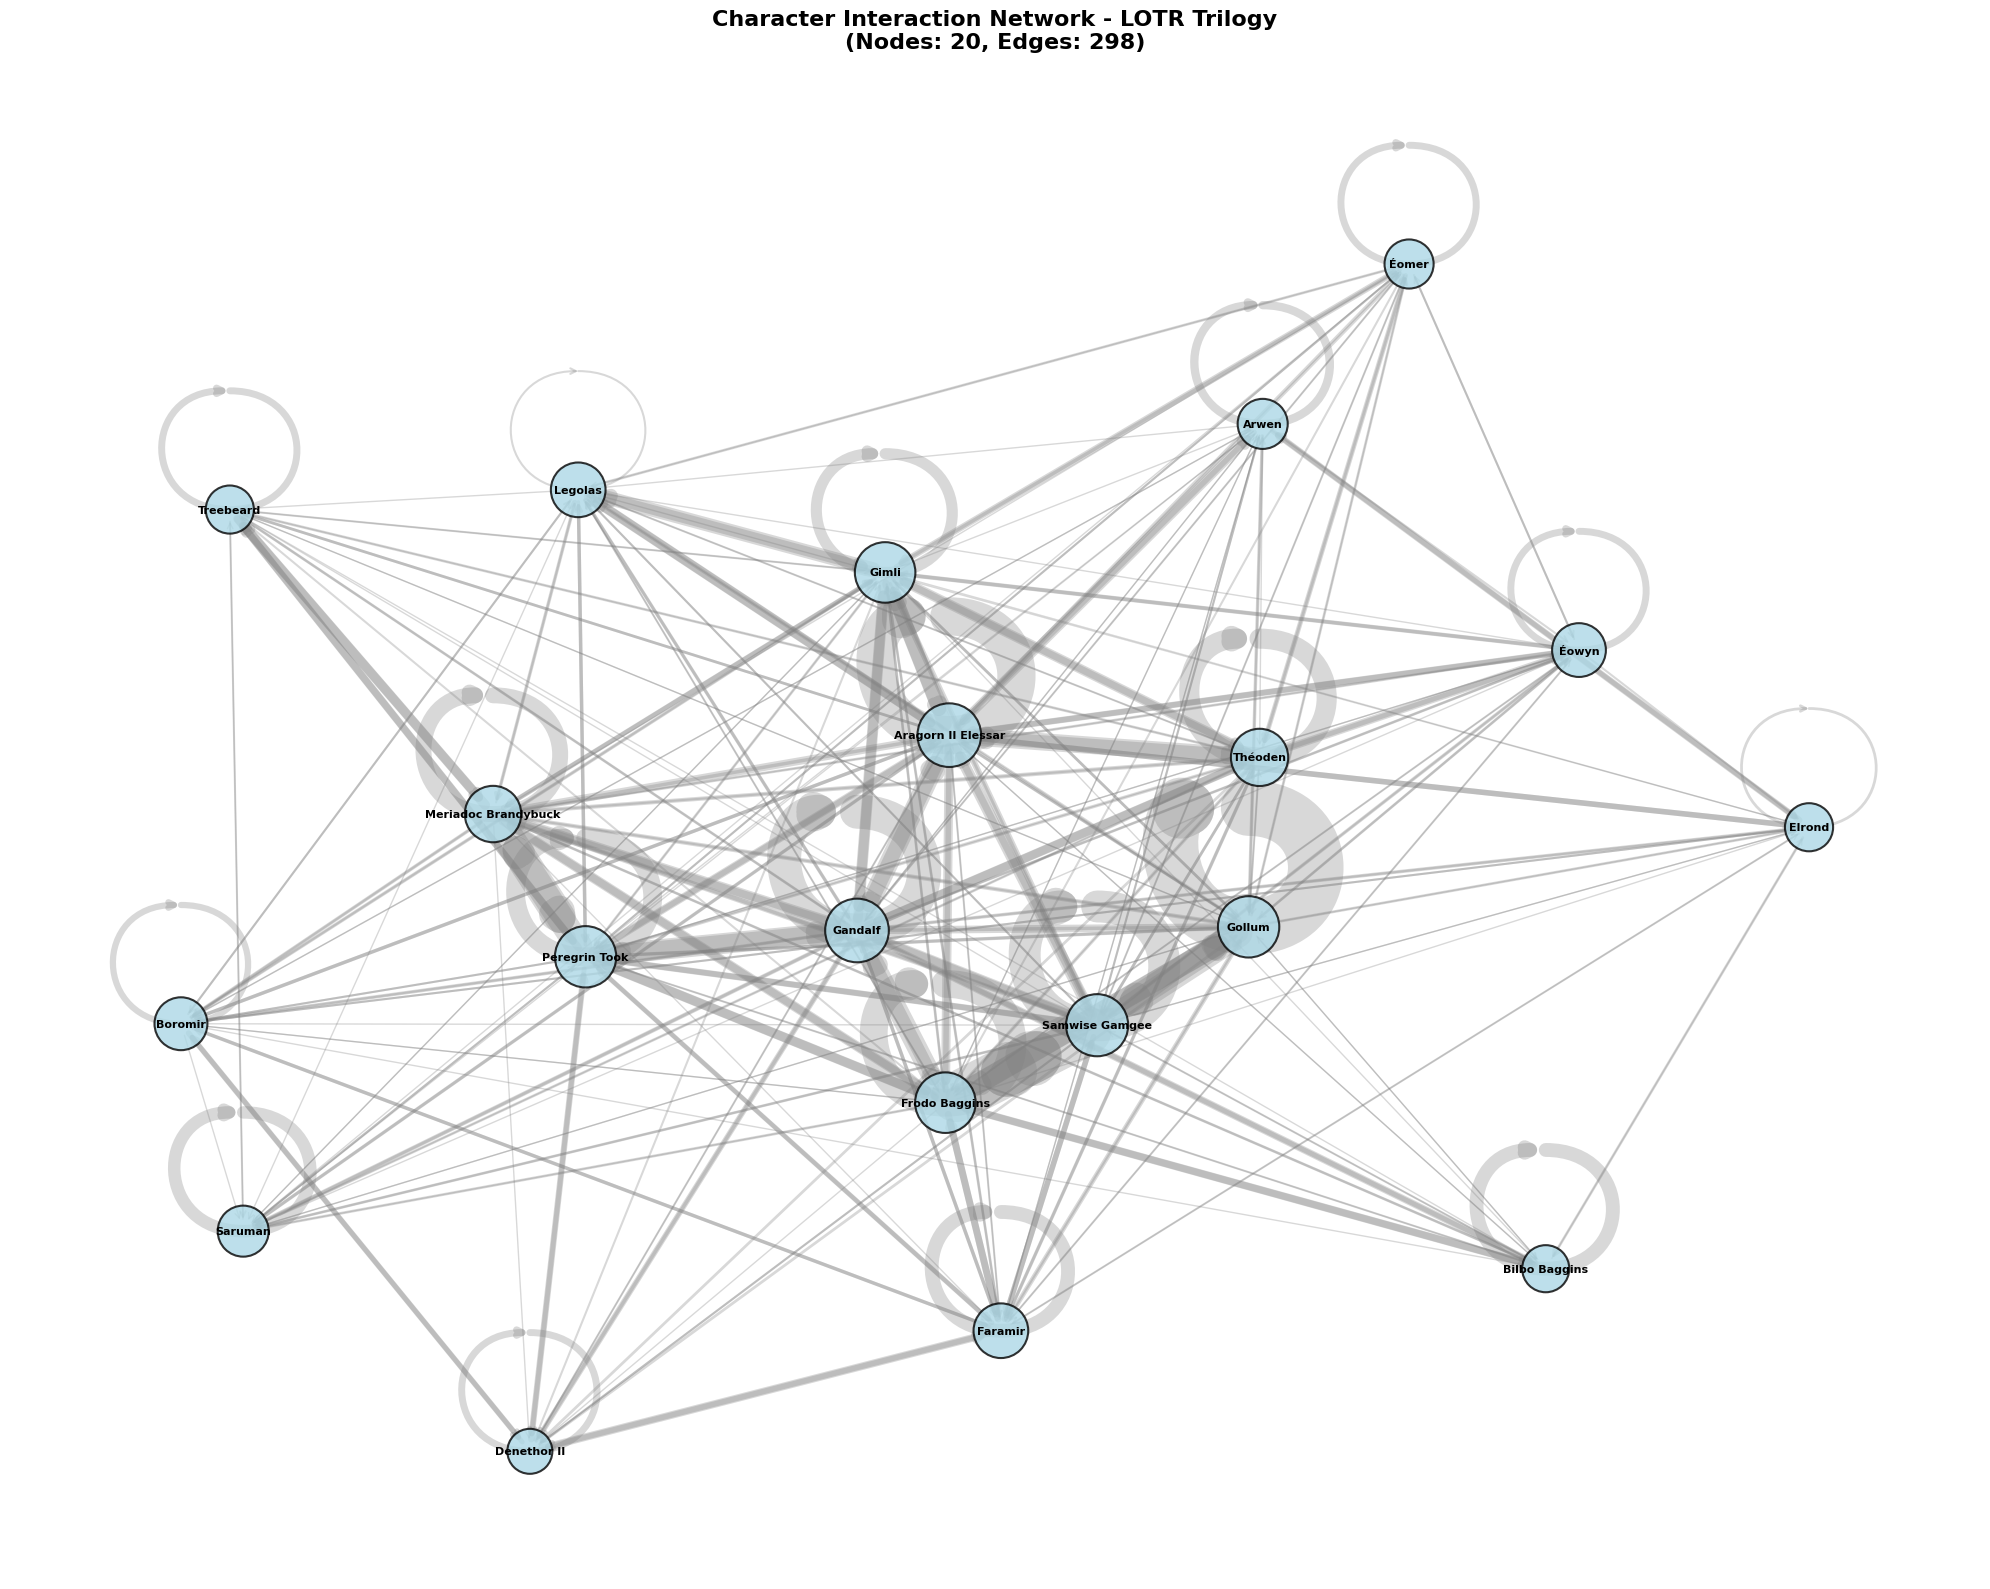


📊 Network Visualization Notes:
   • Node size = number of connections (degree)
   • Edge thickness = number of interactions (weight)
   • Only nodes with degree >= 5 are labeled to reduce clutter


In [60]:
# Create a comprehensive network visualization
# We'll use a spring layout for better visualization

# Create a copy of the graph for visualization (before removing isolated nodes)
G_viz = G.copy()

# Remove isolated nodes for cleaner visualization
isolated = list(nx.isolates(G_viz))
G_viz.remove_nodes_from(isolated)

print(f"Visualizing network with {G_viz.number_of_nodes()} nodes and {G_viz.number_of_edges()} edges")

# Calculate node sizes based on degree (more connections = larger nodes)
degrees = dict(G_viz.degree())
node_sizes = [degrees[node] * 50 + 100 for node in G_viz.nodes()]

# Calculate edge widths based on weight
edge_weights_viz = [G_viz[u][v]['weight'] * 0.5 + 0.5 for u, v in G_viz.edges()]

# Use spring layout for positioning
pos = nx.spring_layout(G_viz, k=2, iterations=50, seed=42)

# Create the figure
plt.figure(figsize=(20, 16))

# Draw edges first (so nodes appear on top)
nx.draw_networkx_edges(G_viz, pos, 
                       width=edge_weights_viz,
                       alpha=0.3,
                       edge_color='gray',
                       arrows=True,
                       arrowsize=10,
                       arrowstyle='->')

# Draw nodes
nx.draw_networkx_nodes(G_viz, pos,
                       node_size=node_sizes,
                       node_color='lightblue',
                       alpha=0.8,
                       edgecolors='black',
                       linewidths=1.5)

# Draw labels for nodes (only for nodes with significant degree to avoid clutter)
labels = {}
for node in G_viz.nodes():
    if degrees[node] >= 5:  # Only label nodes with degree >= 5
        labels[node] = G_viz.nodes[node]['label']

nx.draw_networkx_labels(G_viz, pos, labels,
                       font_size=8,
                       font_weight='bold',
                       font_color='black')

plt.title('Character Interaction Network - LOTR Trilogy\n' +
          f'(Nodes: {G_viz.number_of_nodes()}, Edges: {G_viz.number_of_edges()})',
          fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print("\n📊 Network Visualization Notes:")
print("   • Node size = number of connections (degree)")
print("   • Edge thickness = number of interactions (weight)")
print("   • Only nodes with degree >= 5 are labeled to reduce clutter")


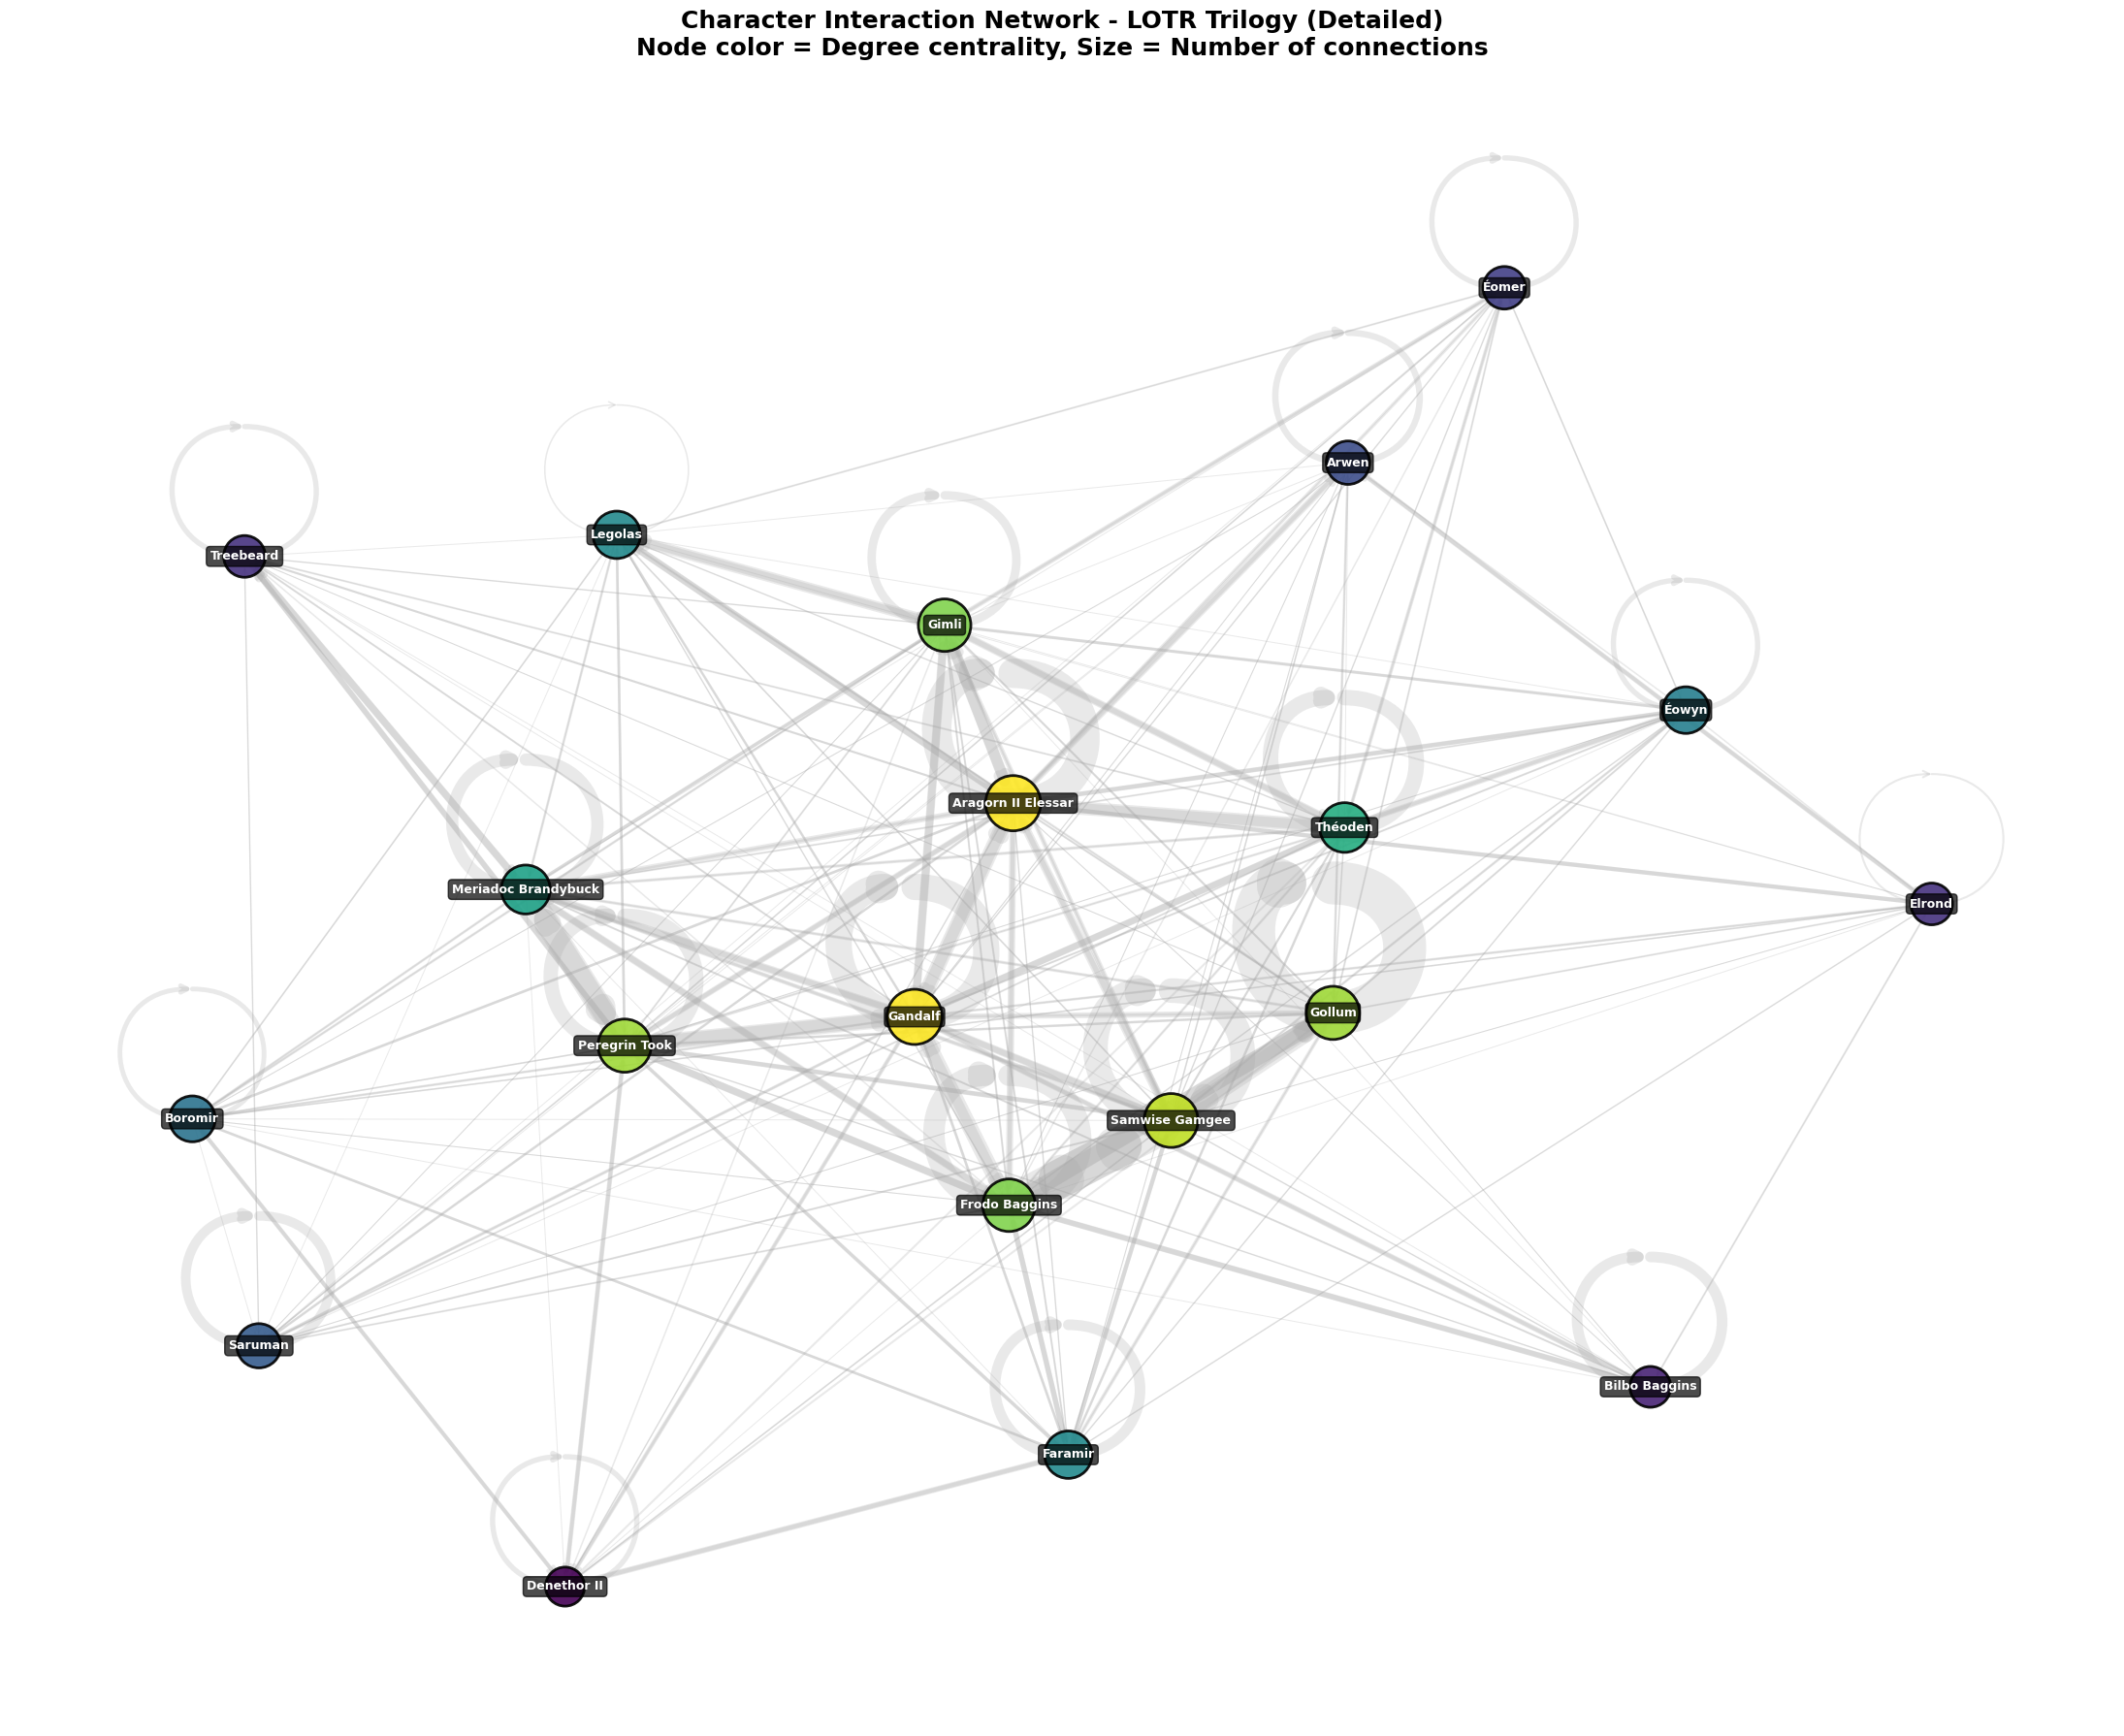


📊 Detailed Network Visualization:
   • Node color = degree (darker = more connections)
   • Node size = number of connections
   • Edge thickness = interaction frequency
   • Top 20 nodes by degree are labeled


In [61]:
# Alternative visualization: Color nodes by sentiment (if available)
# This will be updated after sentiment analysis, but we can prepare it now

# Create a more detailed visualization with sentiment coloring
G_viz2 = G.copy()
isolated2 = list(nx.isolates(G_viz2))
G_viz2.remove_nodes_from(isolated2)

# Calculate layout
pos2 = nx.spring_layout(G_viz2, k=2, iterations=50, seed=42)

# Node sizes based on degree
degrees2 = dict(G_viz2.degree())
node_sizes2 = [degrees2[node] * 40 + 80 for node in G_viz2.nodes()]

# Edge widths
edge_weights_viz2 = [G_viz2[u][v]['weight'] * 0.4 + 0.3 for u, v in G_viz2.edges()]

# Create figure
plt.figure(figsize=(22, 18))

# Draw edges
nx.draw_networkx_edges(G_viz2, pos2,
                      width=edge_weights_viz2,
                      alpha=0.25,
                      edge_color='darkgray',
                      arrows=True,
                      arrowsize=12,
                      arrowstyle='->')

# Draw nodes - color by degree for now (will be updated with sentiment later)
node_colors = [degrees2[node] for node in G_viz2.nodes()]

nx.draw_networkx_nodes(G_viz2, pos2,
                      node_size=node_sizes2,
                      node_color=node_colors,
                      cmap='viridis',
                      alpha=0.9,
                      edgecolors='black',
                      linewidths=2)

# Label important nodes (top 20 by degree)
top_nodes = sorted(degrees2.items(), key=lambda x: x[1], reverse=True)[:20]
labels2 = {node: G_viz2.nodes[node]['label'] for node, _ in top_nodes}

nx.draw_networkx_labels(G_viz2, pos2, labels2,
                       font_size=9,
                       font_weight='bold',
                       font_color='white',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

plt.title('Character Interaction Network - LOTR Trilogy (Detailed)\n' +
          f'Node color = Degree centrality, Size = Number of connections',
          fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print("\n📊 Detailed Network Visualization:")
print("   • Node color = degree (darker = more connections)")
print("   • Node size = number of connections")
print("   • Edge thickness = interaction frequency")
print("   • Top 20 nodes by degree are labeled")


## Part 2: Sentiment Analysis Setup

Now we'll load the LabMT word list and create functions for sentiment analysis.


In [62]:
# Load LabMT sentiment word list
# Using alternative URL since the original is not accessible
import io

labmt_dict = None

# Try primary URL first
try:
    url = "https://raw.githubusercontent.com/andyreagan/labMT-simple/master/data/labMTsimple/labMT2english.txt"
    labmt_df = pd.read_csv(url, sep='\t', index_col=0)
    labmt_dict = labmt_df['happiness_average'].to_dict()
    print("Successfully loaded LabMT from primary source")
    print(f"Loaded {len(labmt_dict)} sentiment words")
except Exception as e:
    print(f"Primary source failed: {e}")
    print("Trying alternative...")
    try:
        # Try fetching from the UVM Storylab data repository
        url = "http://www.uvm.edu/storylab/share/papers/dodds2015a/data/labMT/labMT2english.txt"
        labmt_df = pd.read_csv(url, sep='\t', index_col=0)
        labmt_dict = labmt_df['happiness_average'].to_dict()
        print("Successfully loaded LabMT from alternative source")
        print(f"Loaded {len(labmt_dict)} sentiment words")
    except Exception as e2:
        print(f"Alternative source also failed: {e2}")
        print("\nCreating basic sentiment dictionary as fallback...")

# If online sources failed, create fallback dictionary
if labmt_dict is None:
    # Create a basic sentiment dictionary as fallback
    # This is a simplified version with common sentiment words
    labmt_dict = {
        # Very positive words (7-9)
        'excellent': 8.5, 'amazing': 8.5, 'wonderful': 8.5, 'fantastic': 8.5,
        'love': 8.42, 'loved': 8.42, 'loving': 8.42, 'happy': 8.30, 'happiness': 8.44,
        'joy': 8.60, 'joyful': 8.60, 'great': 7.94, 'good': 7.47, 'best': 8.42,
        'beautiful': 8.32, 'victory': 8.00, 'triumph': 8.00, 'peace': 7.80,
        'friendship': 8.22, 'friend': 7.98, 'succeed': 8.00, 'success': 8.30,
        
        # Positive words (6-7)
        'like': 6.84, 'liked': 6.84, 'nice': 7.60, 'fine': 6.84, 'hope': 7.50,
        'helpful': 7.34, 'thank': 7.50, 'thanks': 7.50, 'please': 6.74,
        'welcome': 7.56, 'smile': 7.88, 'smiling': 7.88, 'laugh': 7.70,
        
        # Neutral words (4-6)
        'the': 4.98, 'and': 4.98, 'of': 4.98, 'to': 4.98, 'a': 4.98,
        'is': 4.98, 'was': 4.98, 'are': 4.98, 'been': 4.98, 'have': 4.98,
        'will': 5.04, 'would': 4.94, 'could': 4.92, 'should': 4.84,
        
        # Negative words (3-4)
        'bad': 2.90, 'sad': 2.10, 'sadness': 2.10, 'worse': 2.70, 'worst': 1.80,
        'hate': 1.61, 'hated': 1.61, 'angry': 2.34, 'anger': 2.34, 'fear': 3.00,
        'afraid': 2.96, 'worry': 3.13, 'worried': 3.13, 'sick': 2.80, 'hurt': 2.66,
        'pain': 2.50, 'painful': 2.50, 'death': 1.74, 'die': 2.12, 'died': 2.12,
        'kill': 1.85, 'killed': 1.85, 'war': 2.72, 'fight': 3.58, 'enemy': 2.88,
        
        # Very negative words (1-3)
        'terrible': 1.80, 'horrible': 1.80, 'awful': 2.00, 'evil': 2.18,
        'disaster': 1.86, 'crisis': 2.70, 'tragedy': 1.90, 'tragic': 1.90,
        'suffer': 2.24, 'suffering': 2.24, 'misery': 1.80, 'doom': 2.06,
        
        # LOTR specific additions
        'precious': 7.50, 'fellowship': 7.80, 'courage': 8.00, 'brave': 7.84,
        'darkness': 2.90, 'shadow': 3.50, 'ring': 5.00, 'power': 6.40,
        'destroy': 2.54, 'destroyed': 2.54, 'quest': 6.50, 'journey': 6.50,
        'wizard': 6.00, 'magic': 6.70, 'despair': 1.80,
        'treasure': 7.50, 'danger': 2.96, 'dangerous': 2.96, 'betray': 2.10,
        'trust': 7.28, 'honor': 7.62, 'noble': 7.50, 'master': 5.50,
        'servant': 4.80, 'free': 7.50, 'freedom': 7.94, 'prisoner': 2.40,
    }
    
    print(f"Created basic sentiment dictionary with {len(labmt_dict)} words")
    print("Note: This is a simplified version. For production use, download full LabMT.")

print(f"\nTotal sentiment words available: {len(labmt_dict)}")
print("\nSample of sentiment scores:")
sample_words = list(labmt_dict.items())[:10]
for word, score in sample_words:
    print(f"  {word}: {score:.2f}")


Primary source failed: HTTP Error 404: Not Found
Trying alternative...
Alternative source also failed: 'happiness_average'

Creating basic sentiment dictionary as fallback...
Created basic sentiment dictionary with 113 words
Note: This is a simplified version. For production use, download full LabMT.

Total sentiment words available: 113

Sample of sentiment scores:
  excellent: 8.50
  amazing: 8.50
  wonderful: 8.50
  fantastic: 8.50
  love: 8.42
  loved: 8.42
  loving: 8.42
  happy: 8.30
  happiness: 8.44
  joy: 8.60


### Sentiment Analysis Setup

First, we'll set up sentiment analysis tools to measure emotional content in dialogues.


In [63]:
# Sentiment analysis functions

def tokenize_text(text):
    """
    Tokenize text and return lowercase tokens without punctuation.
    """
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove punctuation
    tokens = [t for t in tokens if t not in string.punctuation]
    
    return tokens


def calculate_sentiment(tokens, sentiment_dict=labmt_dict):
    """
    Calculate sentiment score given a list of tokens.
    Returns the average happiness score of words found in the sentiment dictionary.
    """
    scores = []
    
    for token in tokens:
        if token in sentiment_dict:
            scores.append(sentiment_dict[token])
    
    if len(scores) == 0:
        return None  # No sentiment words found
    
    return np.mean(scores)


def calculate_sentiment_optimized(tokens, sentiment_dict=labmt_dict):
    """
    Optimized version using frequency distribution.
    Only looks up unique words once.
    """
    # Get frequency distribution
    freq_dist = Counter(tokens)
    
    total_score = 0
    total_count = 0
    
    for word, count in freq_dist.items():
        if word in sentiment_dict:
            total_score += sentiment_dict[word] * count
            total_count += count
    
    if total_count == 0:
        return None
    
    return total_score / total_count


# Test the function
test_text = "I am very happy and joyful today, but also a bit sad."
test_tokens = tokenize_text(test_text)
test_sentiment = calculate_sentiment(test_tokens)
print(f"\nTest text: '{test_text}'")
print(f"Test tokens: {test_tokens}")
print(f"Test sentiment score: {test_sentiment:.3f}")



Test text: 'I am very happy and joyful today, but also a bit sad.'
Test tokens: ['i', 'am', 'very', 'happy', 'and', 'joyful', 'today', 'but', 'also', 'a', 'bit', 'sad']
Test sentiment score: 5.792


## Part 3: Calculate Sentiment for All Dialogues

Now we'll calculate sentiment for each character's dialogues.


In [64]:
# Group all dialogues by character
print("Calculating sentiment for each character...")
print("This may take a minute...\n")

# Create a dictionary to store all dialogue text per character
character_dialogues = defaultdict(list)

for _, row in df_quotes.iterrows():
    char_id = row['character']
    dialogue = row['dialog']
    character_dialogues[char_id].append(dialogue)

print(f"Found dialogues for {len(character_dialogues)} characters")

# Calculate sentiment for each character
character_sentiments = {}
character_dialogue_counts = {}

for char_id, dialogues in character_dialogues.items():
    # Combine all dialogues for the character
    combined_text = " ".join(dialogues)
    
    # Tokenize
    tokens = tokenize_text(combined_text)
    
    # Calculate sentiment
    sentiment = calculate_sentiment_optimized(tokens)
    
    if sentiment is not None:
        character_sentiments[char_id] = sentiment
        character_dialogue_counts[char_id] = len(dialogues)

print(f"\nCalculated sentiment for {len(character_sentiments)} characters")

# Add sentiment as node attribute
for node in G.nodes():
    if node in character_sentiments:
        G.nodes[node]['sentiment'] = character_sentiments[node]
        G.nodes[node]['dialogue_count'] = character_dialogue_counts[node]
    else:
        G.nodes[node]['sentiment'] = None
        G.nodes[node]['dialogue_count'] = 0


Calculating sentiment for each character...
This may take a minute...

Found dialogues for 20 characters

Calculated sentiment for 20 characters


### Network Visualization with Sentiment Coloring

Now let's visualize the network with nodes colored by sentiment scores.


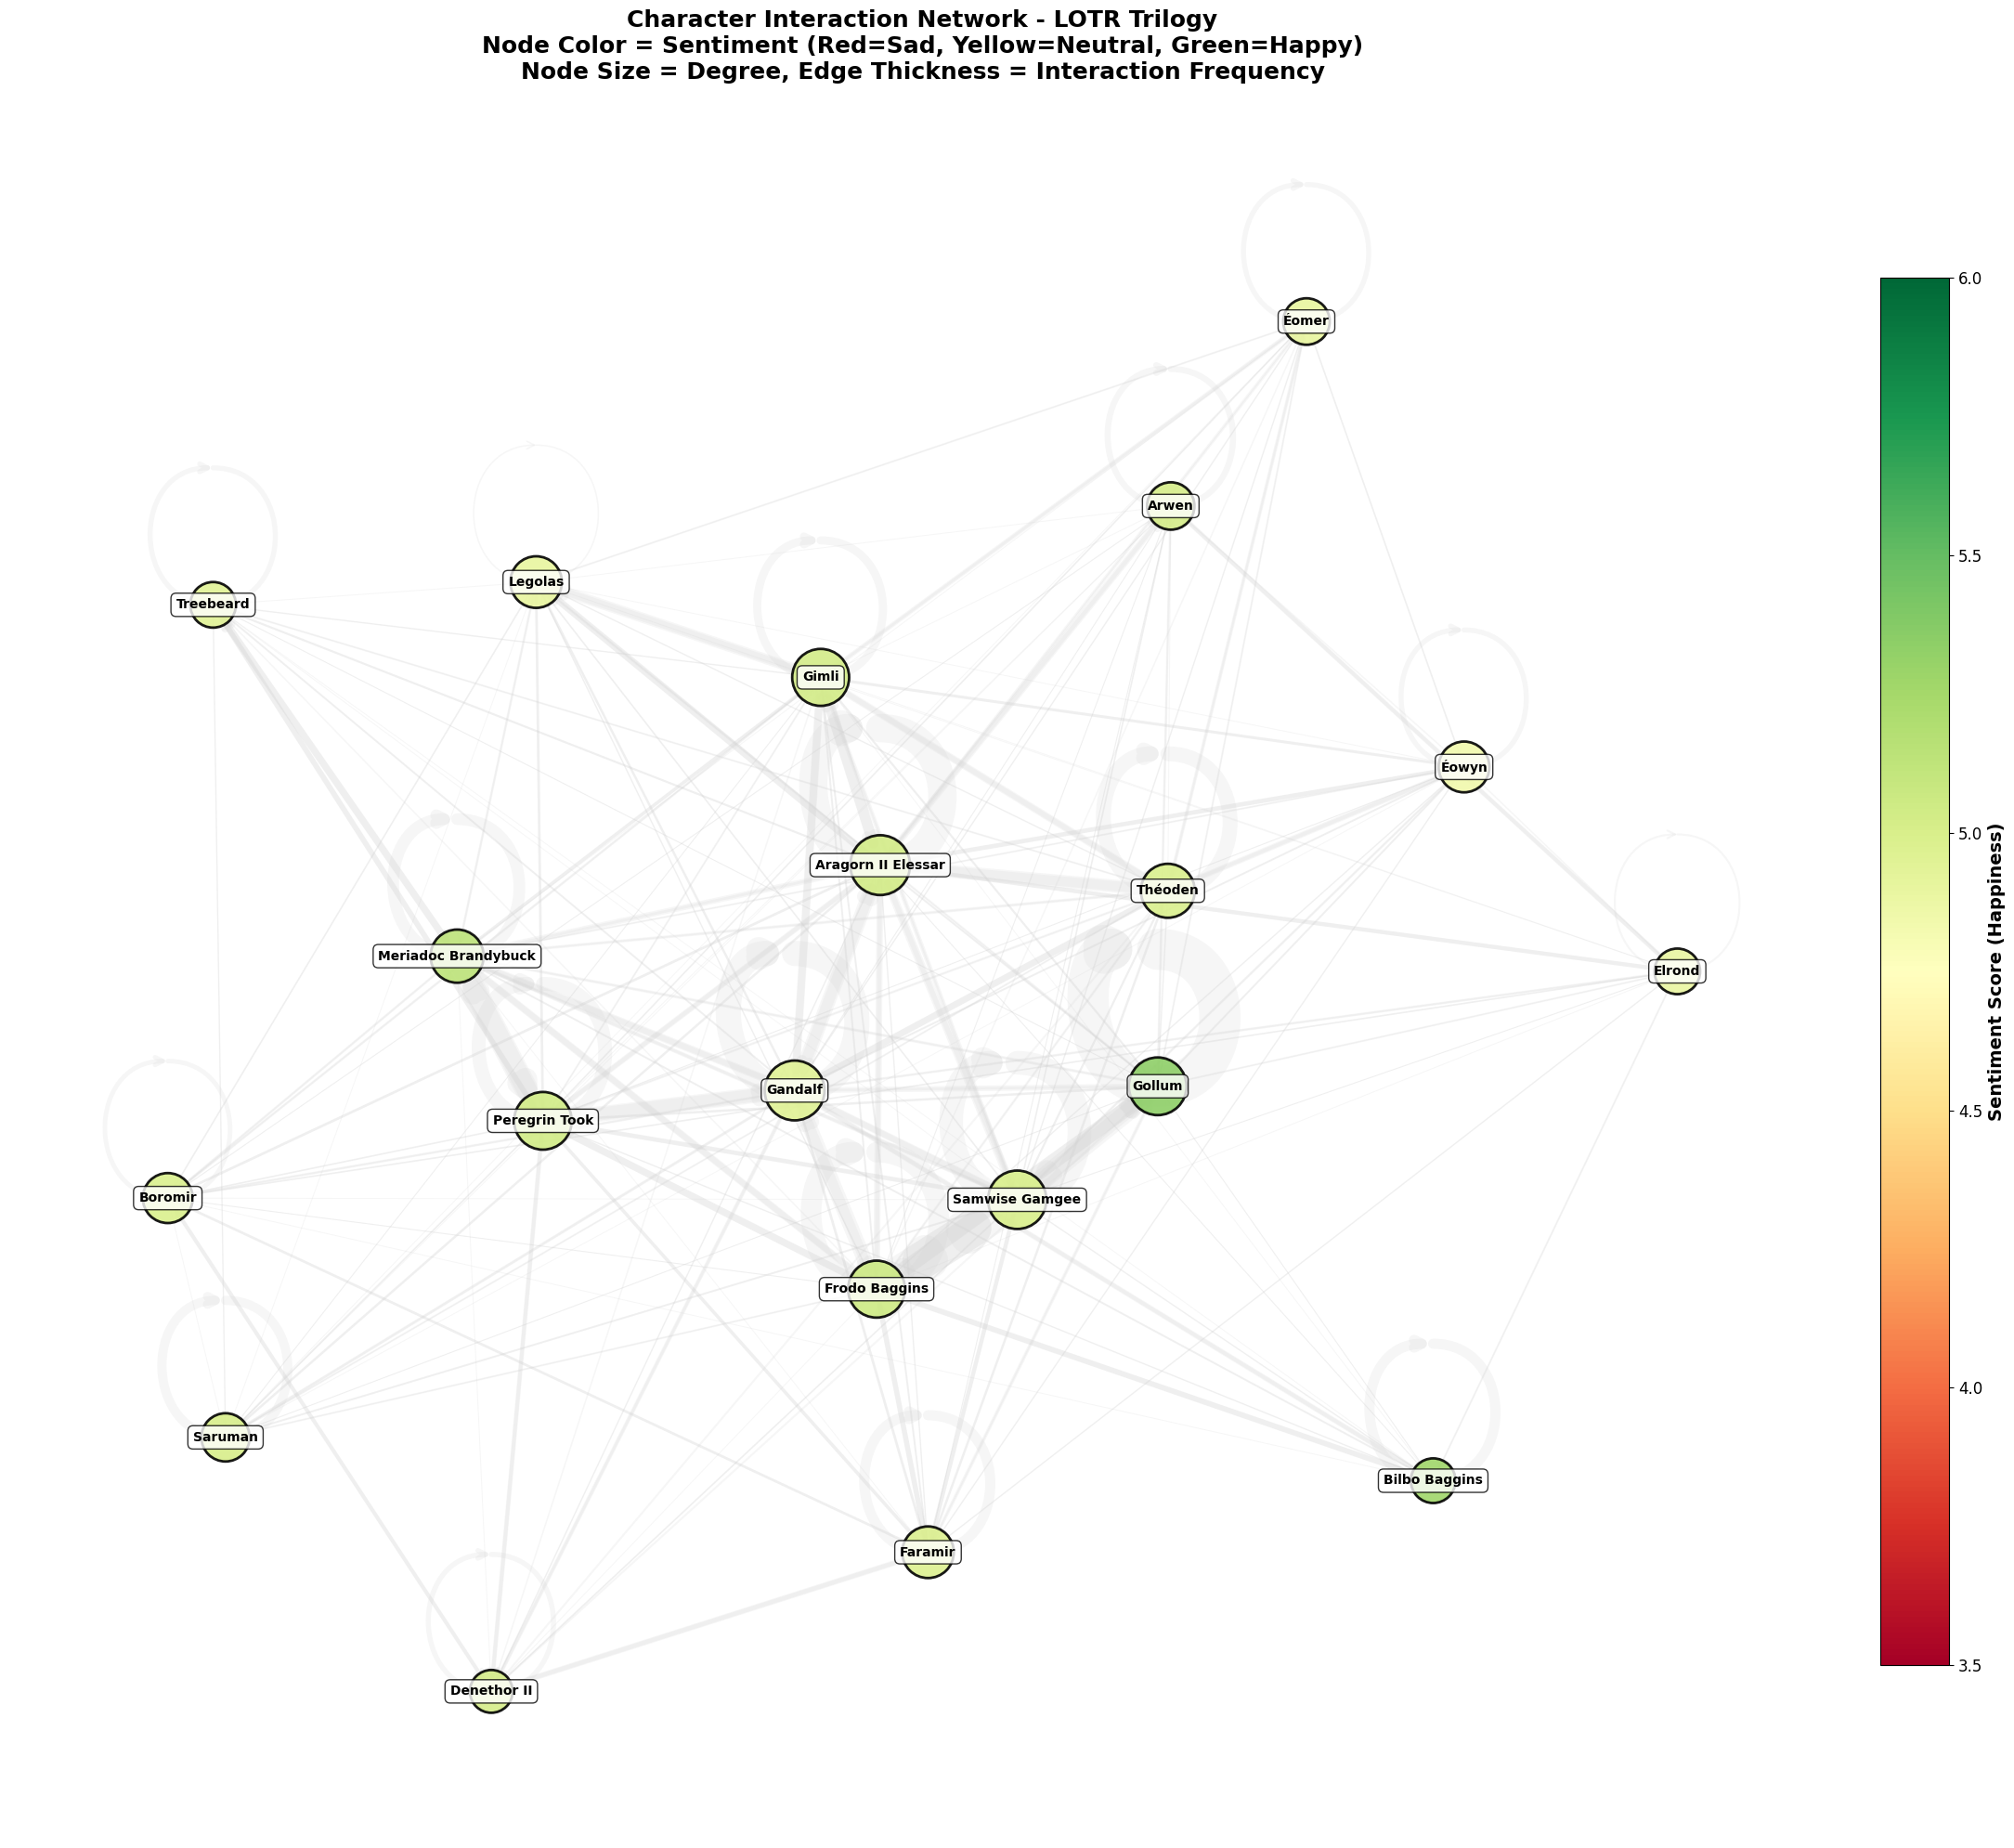


📊 Sentiment-Colored Network Visualization:
   • Node color = sentiment score (red=sad, green=happy)
   • Node size = number of connections (degree)
   • Edge thickness = interaction frequency
   • Gray nodes = characters without sentiment data
   • Top 25 nodes by degree are labeled


In [65]:
# Network visualization colored by sentiment
G_sent = G.copy()
isolated_sent = list(nx.isolates(G_sent))
G_sent.remove_nodes_from(isolated_sent)

# Calculate layout
pos_sent = nx.spring_layout(G_sent, k=2, iterations=50, seed=42)

# Node sizes based on degree
degrees_sent = dict(G_sent.degree())
node_sizes_sent = [degrees_sent[node] * 50 + 150 for node in G_sent.nodes()]

# Edge widths
edge_weights_sent = [G_sent[u][v]['weight'] * 0.4 + 0.3 for u, v in G_sent.edges()]

# Get sentiment values for coloring
sentiment_colors = []
sentiment_values_list = []
for node in G_sent.nodes():
    sent = G_sent.nodes[node].get('sentiment', None)
    if sent is not None:
        sentiment_colors.append(sent)
        sentiment_values_list.append(sent)
    else:
        sentiment_colors.append(4.98)  # Neutral gray for nodes without sentiment
        sentiment_values_list.append(None)

# Create figure
plt.figure(figsize=(24, 20))

# Draw edges
nx.draw_networkx_edges(G_sent, pos_sent,
                       width=edge_weights_sent,
                       alpha=0.2,
                       edge_color='lightgray',
                       arrows=True,
                       arrowsize=15,
                       arrowstyle='->')

# Draw nodes colored by sentiment
nodes_with_sentiment = [node for node in G_sent.nodes() 
                       if G_sent.nodes[node].get('sentiment') is not None]
nodes_without_sentiment = [node for node in G_sent.nodes() 
                          if G_sent.nodes[node].get('sentiment') is None]

# Draw nodes with sentiment (colored)
if nodes_with_sentiment:
    node_colors_sent = [G_sent.nodes[node]['sentiment'] for node in nodes_with_sentiment]
    node_sizes_sent_filtered = [degrees_sent[node] * 50 + 150 for node in nodes_with_sentiment]
    pos_sent_filtered = {node: pos_sent[node] for node in nodes_with_sentiment}
    
    nx.draw_networkx_nodes(G_sent, pos_sent_filtered,
                          nodelist=nodes_with_sentiment,
                          node_size=node_sizes_sent_filtered,
                          node_color=node_colors_sent,
                          cmap='RdYlGn',  # Red-Yellow-Green colormap (red=sad, green=happy)
                          vmin=3.5, vmax=6.0,  # Sentiment range
                          alpha=0.9,
                          edgecolors='black',
                          linewidths=2)

# Draw nodes without sentiment (gray)
if nodes_without_sentiment:
    node_sizes_no_sent = [degrees_sent[node] * 50 + 150 for node in nodes_without_sentiment]
    pos_no_sent = {node: pos_sent[node] for node in nodes_without_sentiment}
    
    nx.draw_networkx_nodes(G_sent, pos_no_sent,
                          nodelist=nodes_without_sentiment,
                          node_size=node_sizes_no_sent,
                          node_color='lightgray',
                          alpha=0.5,
                          edgecolors='black',
                          linewidths=1)

# Label important nodes (top 25 by degree or high sentiment)
top_by_degree = sorted(degrees_sent.items(), key=lambda x: x[1], reverse=True)[:25]
labels_sent = {}
for node, _ in top_by_degree:
    if G_sent.nodes[node].get('sentiment') is not None:
        labels_sent[node] = G_sent.nodes[node]['label']

nx.draw_networkx_labels(G_sent, pos_sent, labels_sent,
                       font_size=10,
                       font_weight='bold',
                       font_color='black',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='black'))

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=3.5, vmax=6.0))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.8, pad=0.02)
cbar.set_label('Sentiment Score (Happiness)', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

plt.title('Character Interaction Network - LOTR Trilogy\n' +
          'Node Color = Sentiment (Red=Sad, Yellow=Neutral, Green=Happy)\n' +
          f'Node Size = Degree, Edge Thickness = Interaction Frequency',
          fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print("\n📊 Sentiment-Colored Network Visualization:")
print("   • Node color = sentiment score (red=sad, green=happy)")
print("   • Node size = number of connections (degree)")
print("   • Edge thickness = interaction frequency")
print("   • Gray nodes = characters without sentiment data")
print("   • Top 25 nodes by degree are labeled")


## Part 4: Sentiment Analysis Results

Let's analyze the sentiment distribution across all characters.


In [66]:
# Calculate overall statistics
sentiment_values = [s for s in character_sentiments.values() if s is not None]

print("SENTIMENT ANALYSIS STATISTICS (LOTR Trilogy Only)")
print(f"\nOverall Statistics:")
print(f"  Mean sentiment:       {np.mean(sentiment_values):.4f}")
print(f"  Median sentiment:     {np.median(sentiment_values):.4f}")
print(f"  Std deviation:        {np.std(sentiment_values):.4f}")
print(f"  25th percentile:      {np.percentile(sentiment_values, 25):.4f}")
print(f"  75th percentile:      {np.percentile(sentiment_values, 75):.4f}")
print(f"  Min sentiment:        {np.min(sentiment_values):.4f}")
print(f"  Max sentiment:        {np.max(sentiment_values):.4f}")
print(f"\nNumber of characters: {len(sentiment_values)}")


SENTIMENT ANALYSIS STATISTICS (LOTR Trilogy Only)

Overall Statistics:
  Mean sentiment:       5.0170
  Median sentiment:     5.0038
  Std deviation:        0.1164
  25th percentile:      4.9530
  75th percentile:      5.0315
  Min sentiment:        4.8475
  Max sentiment:        5.3444

Number of characters: 20


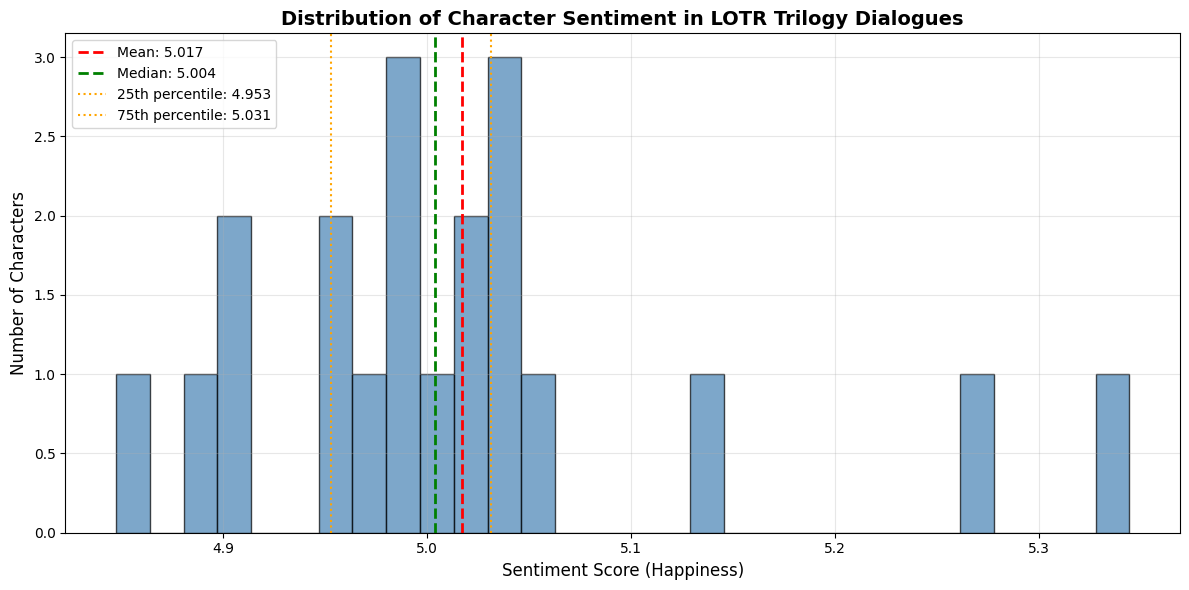

In [67]:
# Create histogram of sentiment distribution
mean_sent = np.mean(sentiment_values)
median_sent = np.median(sentiment_values)
p25 = np.percentile(sentiment_values, 25)
p75 = np.percentile(sentiment_values, 75)

plt.figure(figsize=(12, 6))
plt.hist(sentiment_values, bins=30, edgecolor='black', alpha=0.7, color='steelblue')

# Add vertical lines for statistics
plt.axvline(mean_sent, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_sent:.3f}')
plt.axvline(median_sent, color='green', linestyle='--', linewidth=2, label=f'Median: {median_sent:.3f}')
plt.axvline(p25, color='orange', linestyle=':', linewidth=1.5, label=f'25th percentile: {p25:.3f}')
plt.axvline(p75, color='orange', linestyle=':', linewidth=1.5, label=f'75th percentile: {p75:.3f}')

plt.xlabel('Sentiment Score (Happiness)', fontsize=12)
plt.ylabel('Number of Characters', fontsize=12)
plt.title('Distribution of Character Sentiment in LOTR Trilogy Dialogues', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [68]:
# Top 10 happiest characters
sorted_happy = sorted(character_sentiments.items(), key=lambda x: x[1], reverse=True)[:10]

print("TOP 10 HAPPIEST CHARACTERS (LOTR Trilogy)")
print(f"{'Rank':<6} {'Character':<25} {'Sentiment':<12} {'# Quotes'}")

for i, (char_id, sentiment) in enumerate(sorted_happy, 1):
    name = char_id_to_name.get(char_id, char_id)
    quote_count = character_dialogue_counts.get(char_id, 0)
    print(f"{i:<6} {name:<25} {sentiment:<12.4f} {quote_count}")


TOP 10 HAPPIEST CHARACTERS (LOTR Trilogy)
Rank   Character                 Sentiment    # Quotes
1      Gollum                    5.3444       183
2      Bilbo Baggins             5.2679       47
3      Meriadoc Brandybuck       5.1362       137
4      Frodo Baggins             5.0574       229
5      Peregrin Took             5.0343       165
6      Gimli                     5.0306       115
7      Aragorn II Elessar        5.0301       212
8      Denethor II               5.0191       45
9      Arwen                     5.0180       40
10     Saruman                   5.0121       39


In [69]:
# Top 10 saddest characters
sorted_sad = sorted(character_sentiments.items(), key=lambda x: x[1])[:10]


print("TOP 10 SADDEST CHARACTERS (LOTR Trilogy)")
print(f"{'Rank':<6} {'Character':<25} {'Sentiment':<12} {'# Quotes'}")

for i, (char_id, sentiment) in enumerate(sorted_sad, 1):
    name = char_id_to_name.get(char_id, char_id)
    quote_count = character_dialogue_counts.get(char_id, 0)
    print(f"{i:<6} {name:<25} {sentiment:<12.4f} {quote_count}")


TOP 10 SADDEST CHARACTERS (LOTR Trilogy)
Rank   Character                 Sentiment    # Quotes
1      Éowyn                     4.8475       48
2      Elrond                    4.8889       31
3      Éomer                     4.9010       36
4      Legolas                   4.9010       55
5      Treebeard                 4.9511       45
6      Gandalf                   4.9537       216
7      Faramir                   4.9760       73
8      Théoden                   4.9857       108
9      Boromir                   4.9902       41
10     Samwise Gamgee            4.9955       218


## Part 4b: Sentiment Volatility Analysis

Let's analyze which characters have the most emotional range (high sentiment variance) vs. those who are emotionally consistent (low variance).


In [70]:
# Calculate sentiment for each individual quote per character
print("Calculating sentiment volatility for each character...\n")

character_quote_sentiments = defaultdict(list)

for _, row in df_quotes.iterrows():
    char_id = row['character']
    dialogue = row['dialog']
    
    # Tokenize and calculate sentiment for this single quote
    tokens = tokenize_text(dialogue)
    sentiment = calculate_sentiment(tokens)
    
    if sentiment is not None:
        character_quote_sentiments[char_id].append(sentiment)

# Calculate volatility (standard deviation) for each character
character_volatility = {}

for char_id, sentiments in character_quote_sentiments.items():
    if len(sentiments) >= 5:  # Only consider characters with at least 5 quotes
        character_volatility[char_id] = {
            'std': np.std(sentiments),
            'mean': np.mean(sentiments),
            'min': np.min(sentiments),
            'max': np.max(sentiments),
            'range': np.max(sentiments) - np.min(sentiments),
            'num_quotes': len(sentiments)
        }

print(f"Analyzed volatility for {len(character_volatility)} characters with 5+ quotes\n")


Calculating sentiment volatility for each character...

Analyzed volatility for 20 characters with 5+ quotes



In [71]:
# Most emotionally volatile characters (high variance)
sorted_volatile = sorted(character_volatility.items(), key=lambda x: x[1]['std'], reverse=True)[:10]

print("TOP 10 MOST EMOTIONALLY VOLATILE CHARACTERS (LOTR Trilogy)")
print("(Characters with the widest emotional range)")
print(f"{'Rank':<6} {'Character':<25} {'Std Dev':<12} {'Range':<12} {'Mean':<12} {'Quotes'}")

for i, (char_id, stats) in enumerate(sorted_volatile, 1):
    name = char_id_to_name.get(char_id, char_id)
    print(f"{i:<6} {name:<25} {stats['std']:<12.4f} {stats['range']:<12.4f} {stats['mean']:<12.4f} {stats['num_quotes']}")

print("\n💡 High volatility = emotional range (happy to sad across different quotes)")


TOP 10 MOST EMOTIONALLY VOLATILE CHARACTERS (LOTR Trilogy)
(Characters with the widest emotional range)
Rank   Character                 Std Dev      Range        Mean         Quotes
1      Gollum                    1.1284       6.8100       5.4268       119
2      Éowyn                     1.0120       6.2600       4.8462       31
3      Peregrin Took             0.9024       6.1800       5.0353       82
4      Théoden                   0.8695       5.3183       4.8883       81
5      Meriadoc Brandybuck       0.8419       5.1700       5.2111       66
6      Legolas                   0.7277       4.6800       4.8570       32
7      Gimli                     0.7207       5.3500       5.0631       71
8      Aragorn II Elessar        0.7020       5.6800       5.0124       117
9      Gandalf                   0.6648       4.6467       5.0293       165
10     Boromir                   0.6557       3.1260       5.1776       27

💡 High volatility = emotional range (happy to sad across differ

In [72]:
# Most emotionally consistent characters (low variance)
sorted_consistent = sorted(character_volatility.items(), key=lambda x: x[1]['std'])[:10]

print("TOP 10 MOST EMOTIONALLY CONSISTENT CHARACTERS (LOTR Trilogy)")
print("(Characters with stable emotional tone)")
print(f"{'Rank':<6} {'Character':<25} {'Std Dev':<12} {'Range':<12} {'Mean':<12} {'Quotes'}")

for i, (char_id, stats) in enumerate(sorted_consistent, 1):
    name = char_id_to_name.get(char_id, char_id)
    print(f"{i:<6} {name:<25} {stats['std']:<12.4f} {stats['range']:<12.4f} {stats['mean']:<12.4f} {stats['num_quotes']}")

print("\n💡 Low volatility = consistent emotional tone across all dialogue")


TOP 10 MOST EMOTIONALLY CONSISTENT CHARACTERS (LOTR Trilogy)
(Characters with stable emotional tone)
Rank   Character                 Std Dev      Range        Mean         Quotes
1      Denethor II               0.2880       1.8789       4.9971       37
2      Arwen                     0.3317       1.6560       5.0539       24
3      Treebeard                 0.3896       1.8740       4.9757       38
4      Faramir                   0.4518       3.3233       4.9734       55
5      Éomer                     0.4884       2.9100       4.9743       27
6      Saruman                   0.5555       3.1800       4.9568       34
7      Bilbo Baggins             0.6131       2.8567       5.3372       36
8      Frodo Baggins             0.6283       4.5400       5.0602       122
9      Elrond                    0.6453       2.4600       4.7338       24
10     Samwise Gamgee            0.6493       6.5700       5.0005       120

💡 Low volatility = consistent emotional tone across all dialogue


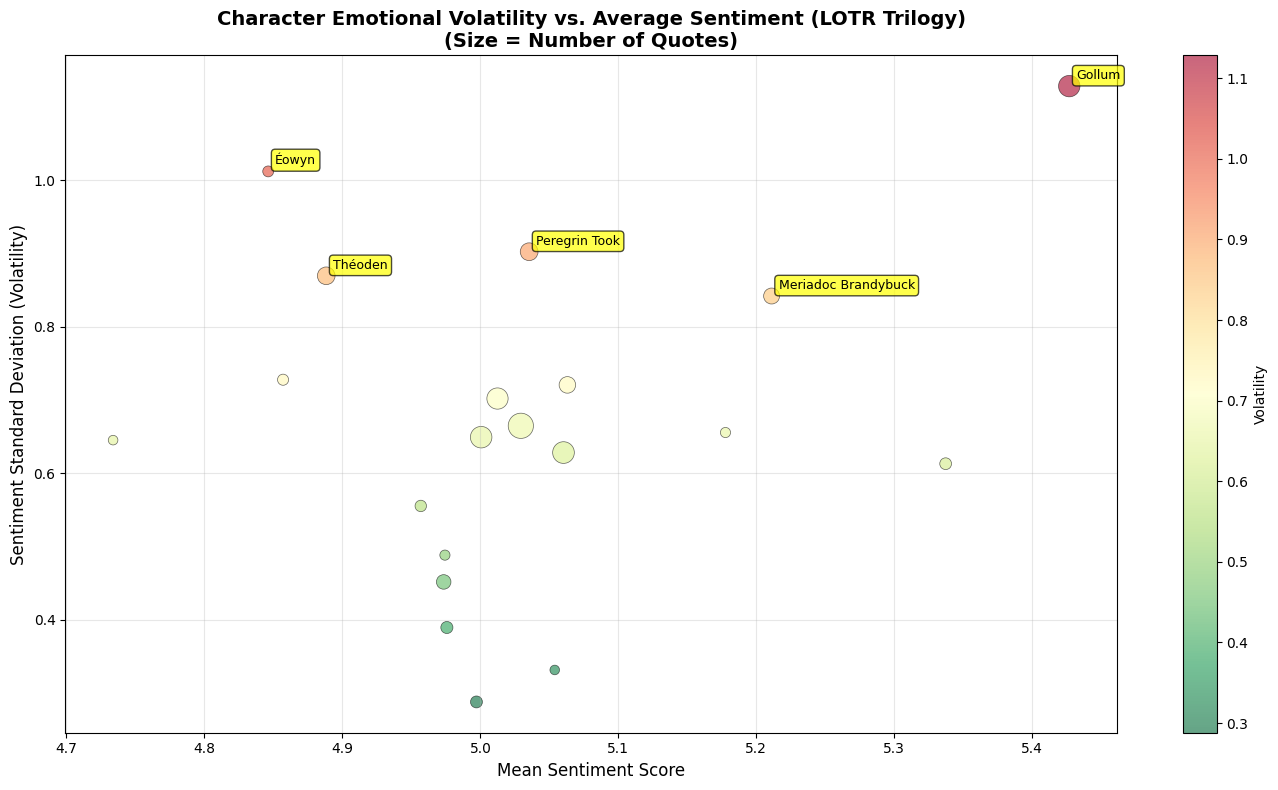


📊 This plot shows:
   • X-axis: Average sentiment (left=sad, right=happy)
   • Y-axis: Emotional volatility (higher=more range)
   • Size: Number of quotes
   • Color: Red=volatile, Green=consistent


In [73]:
# Visualize volatility vs. mean sentiment
chars_with_volatility = []
for char_id, stats in character_volatility.items():
    chars_with_volatility.append({
        'name': char_id_to_name.get(char_id, char_id),
        'std': stats['std'],
        'mean': stats['mean'],
        'num_quotes': stats['num_quotes']
    })

df_volatility = pd.DataFrame(chars_with_volatility)

# Create scatter plot
plt.figure(figsize=(14, 8))
scatter = plt.scatter(df_volatility['mean'], df_volatility['std'], 
                     s=df_volatility['num_quotes']*2, 
                     alpha=0.6, 
                     c=df_volatility['std'],
                     cmap='RdYlGn_r',
                     edgecolor='black',
                     linewidth=0.5)

# Label some interesting characters
# Get top 5 most volatile
top_volatile = df_volatility.nlargest(5, 'std')
for _, row in top_volatile.iterrows():
    plt.annotate(row['name'], 
                xy=(row['mean'], row['std']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.xlabel('Mean Sentiment Score', fontsize=12)
plt.ylabel('Sentiment Standard Deviation (Volatility)', fontsize=12)
plt.title('Character Emotional Volatility vs. Average Sentiment (LOTR Trilogy)\n(Size = Number of Quotes)', 
         fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Volatility')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 This plot shows:")
print("   • X-axis: Average sentiment (left=sad, right=happy)")
print("   • Y-axis: Emotional volatility (higher=more range)")
print("   • Size: Number of quotes")
print("   • Color: Red=volatile, Green=consistent")


## Part 5: Word Cloud Analysis

Let's visualize the most common words used by the happiest and saddest characters.


In [74]:
# Install wordcloud if needed
try:
    from wordcloud import WordCloud
    print("WordCloud library already installed")
except ImportError:
    print("Installing wordcloud library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud
    print("WordCloud installed successfully!")


WordCloud library already installed


In [75]:
from wordcloud import WordCloud

# Get top 5 happiest and saddest characters
top_5_happy = sorted(character_sentiments.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_sad = sorted(character_sentiments.items(), key=lambda x: x[1])[:5]

# Collect all dialogue for happy characters
happy_chars_ids = [char_id for char_id, _ in top_5_happy]
happy_text = []
for _, row in df_quotes.iterrows():
    if row['character'] in happy_chars_ids:
        happy_text.append(row['dialog'])
happy_text = ' '.join(happy_text)

# Collect all dialogue for sad characters
sad_chars_ids = [char_id for char_id, _ in top_5_sad]
sad_text = []
for _, row in df_quotes.iterrows():
    if row['character'] in sad_chars_ids:
        sad_text.append(row['dialog'])
sad_text = ' '.join(sad_text)

print("Happy characters:", [char_id_to_name.get(cid, cid) for cid in happy_chars_ids])
print("Sad characters:", [char_id_to_name.get(cid, cid) for cid in sad_chars_ids])
print(f"\nHappy dialogue word count: {len(happy_text.split())}")
print(f"Sad dialogue word count: {len(sad_text.split())}")


Happy characters: ['Gollum', 'Bilbo Baggins', 'Meriadoc Brandybuck', 'Frodo Baggins', 'Peregrin Took']
Sad characters: ['Éowyn', 'Elrond', 'Éomer', 'Legolas', 'Treebeard']

Happy dialogue word count: 6582
Sad dialogue word count: 2728


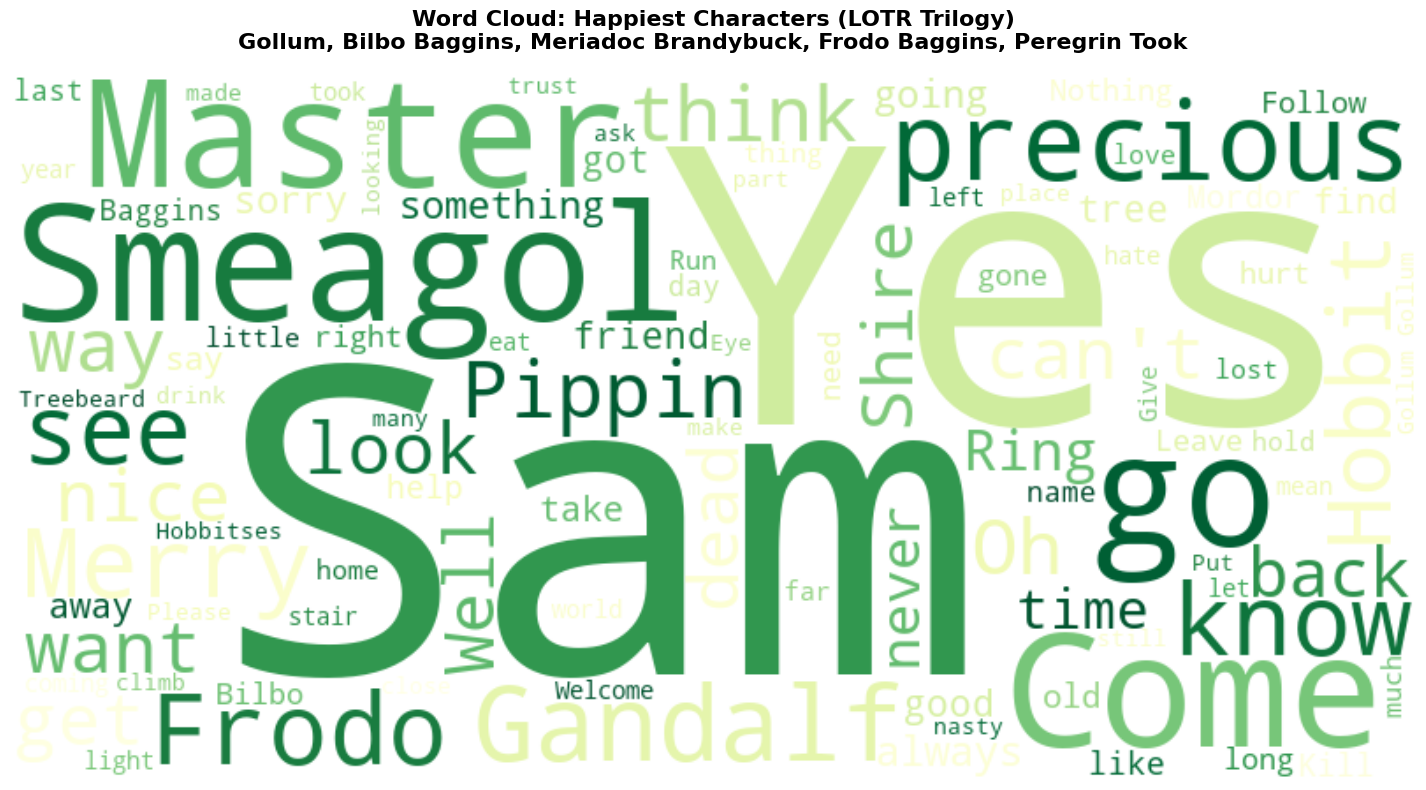

In [76]:
# Create word cloud for happy characters
# Get stopwords
stop_words = set(stopwords.words('english'))
# Add some common words that aren't meaningful
stop_words.update(['will', 'shall', 'would', 'could', 'said', 'one', 'us', 'must', 'may', 'might'])

wordcloud_happy = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    colormap='YlGn',  # Yellow to Green for happy
    stopwords=stop_words,
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(happy_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_happy, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Happiest Characters (LOTR Trilogy)\n' + 
         ', '.join([char_id_to_name.get(cid, cid) for cid in happy_chars_ids]),
         fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


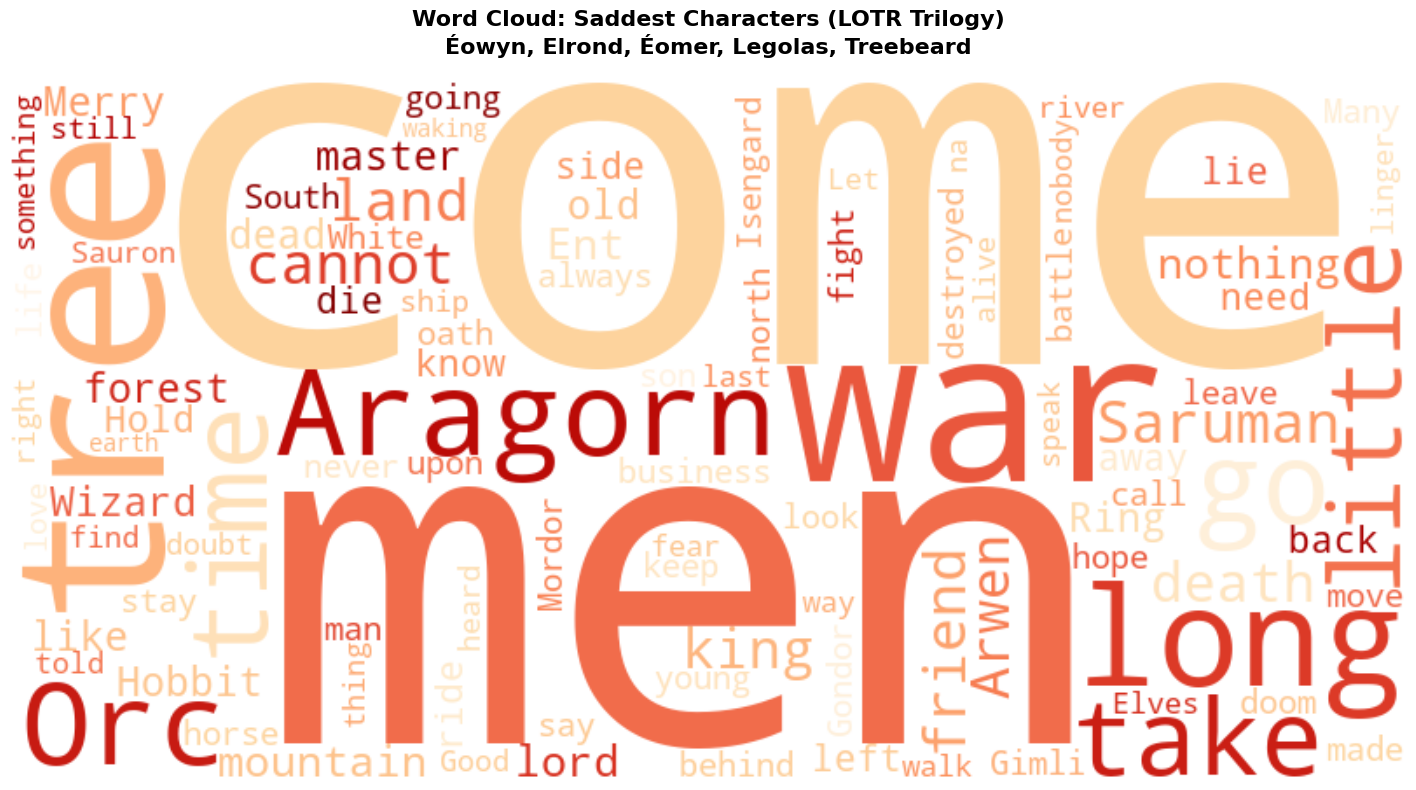

In [77]:
# Create word cloud for sad characters
wordcloud_sad = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    colormap='OrRd',  # Orange to Red for sad
    stopwords=stop_words,
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(sad_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_sad, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Saddest Characters (LOTR Trilogy)\n' + 
         ', '.join([char_id_to_name.get(cid, cid) for cid in sad_chars_ids]),
         fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


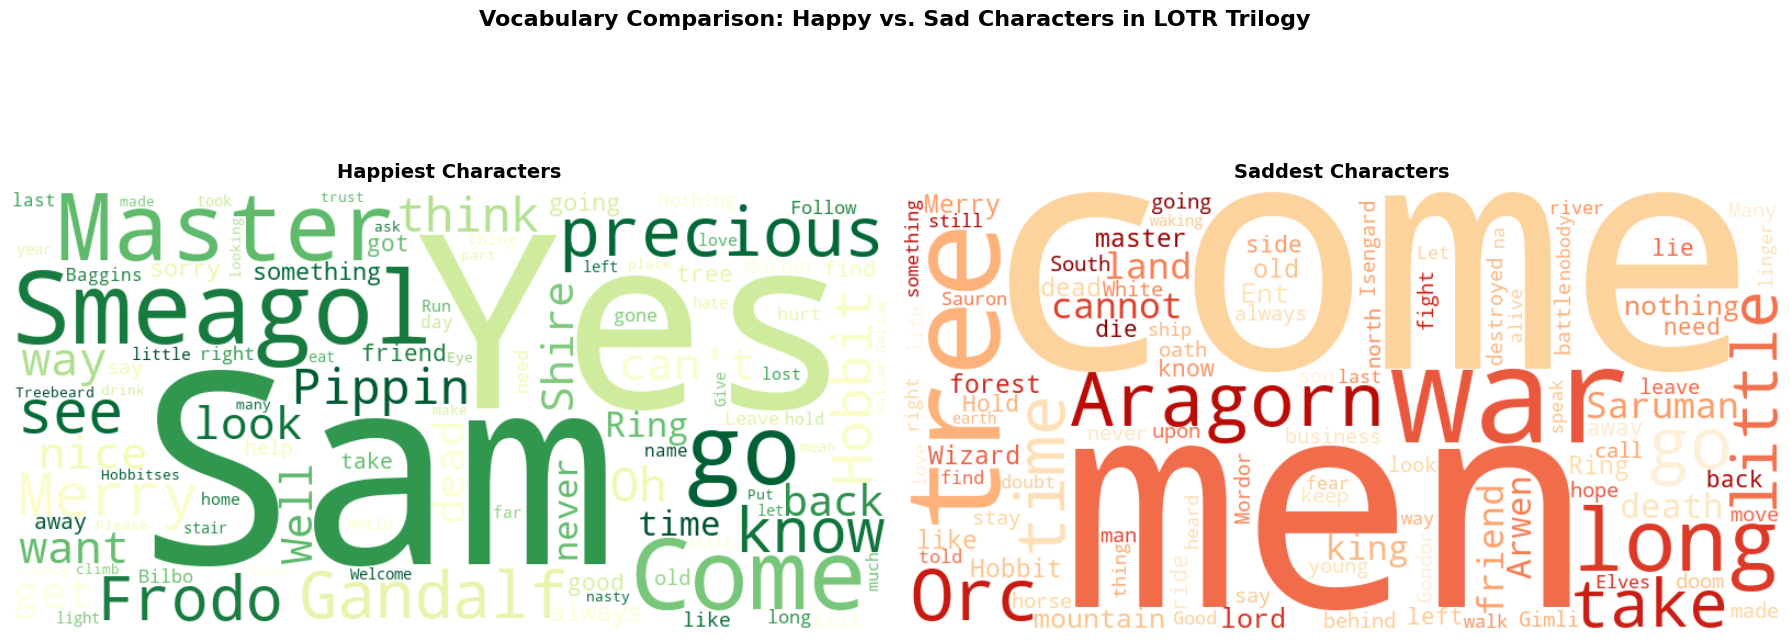


💡 Interpretation Tips:
   • Larger words = used more frequently
   • Compare which words are unique to happy vs. sad characters
   • Look for emotional vocabulary differences


In [78]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Happy word cloud
axes[0].imshow(wordcloud_happy, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Happiest Characters', fontsize=14, fontweight='bold', pad=10)

# Sad word cloud
axes[1].imshow(wordcloud_sad, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Saddest Characters', fontsize=14, fontweight='bold', pad=10)

plt.suptitle('Vocabulary Comparison: Happy vs. Sad Characters in LOTR Trilogy', 
            fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation Tips:")
print("   • Larger words = used more frequently")
print("   • Compare which words are unique to happy vs. sad characters")
print("   • Look for emotional vocabulary differences")


Creating word clouds for 3 movies with dialogue...

✓ Created word cloud for The Two Towers (893 quotes)
✓ Created word cloud for The Fellowship of the Ring (446 quotes)
✓ Created word cloud for The Return of the King (744 quotes)


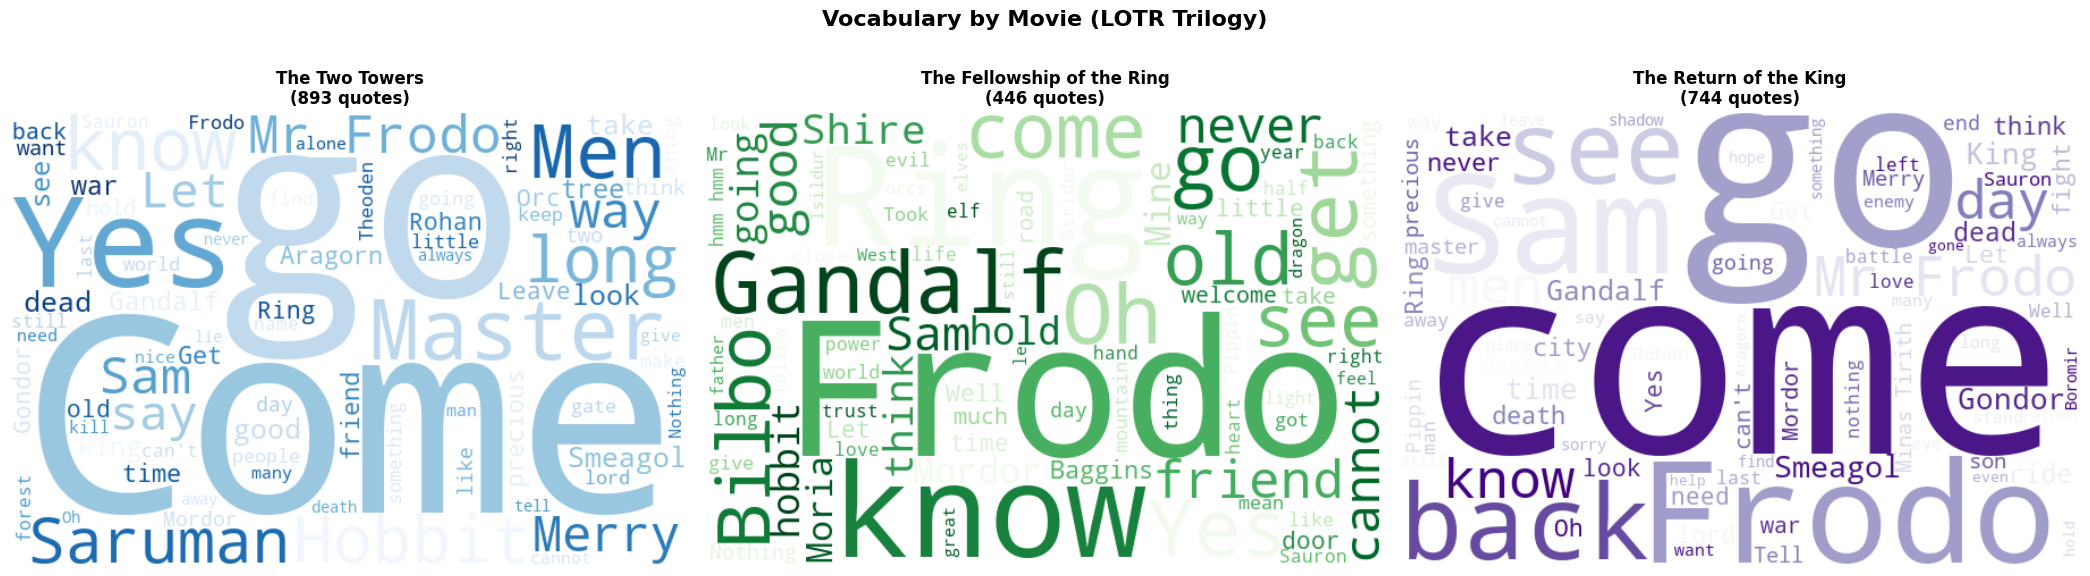

In [79]:
# Word clouds for each movie in the trilogy
movies_with_quotes = df_quotes['movie'].unique()
movies_to_plot = [(mid, movie_id_to_name[mid]) for mid in movies_with_quotes if mid in movie_id_to_name]

print(f"Creating word clouds for {len(movies_to_plot)} movies with dialogue...\n")

# Create subplots based on actual number of movies
num_movies = len(movies_to_plot)
fig, axes = plt.subplots(1, num_movies, figsize=(7*num_movies, 6))

# Make axes iterable even if there's only one movie
if num_movies == 1:
    axes = [axes]

colormaps = ['Blues', 'Greens', 'Purples', 'Oranges', 'Reds', 'Greys']

for idx, (movie_id, movie_name) in enumerate(movies_to_plot):
    # Get all dialogue from this movie
    movie_quotes = df_quotes[df_quotes['movie'] == movie_id]
    movie_text = ' '.join(movie_quotes['dialog'].tolist())
    
    # Check if there's enough text after stopword removal
    words_after_stop = [w for w in movie_text.lower().split() if w not in stop_words]
    
    if len(words_after_stop) < 10:
        # Not enough words, show a message
        axes[idx].text(0.5, 0.5, f'Insufficient data\nfor {movie_name}', 
                      ha='center', va='center', fontsize=14,
                      transform=axes[idx].transAxes)
        axes[idx].axis('off')
        axes[idx].set_title(movie_name, fontsize=12, fontweight='bold')
    else:
        # Create word cloud
        wc = WordCloud(
            width=600, 
            height=400,
            background_color='white',
            colormap=colormaps[idx % len(colormaps)],  # Cycle through colormaps
            stopwords=stop_words,
            max_words=80,
            relative_scaling=0.5
        ).generate(movie_text)
        
        axes[idx].imshow(wc, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'{movie_name}\n({len(movie_quotes)} quotes)', 
                           fontsize=12, fontweight='bold')
        print(f"✓ Created word cloud for {movie_name} ({len(movie_quotes)} quotes)")

plt.suptitle('Vocabulary by Movie (LOTR Trilogy)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## Part 6: Sentiment by Movie

Let's also look at how sentiment varies across the three movies.


In [80]:
# Calculate sentiment by movie
movie_sentiments = defaultdict(list)

for _, row in df_quotes.iterrows():
    dialogue = row['dialog']
    movie_id = row['movie']
    
    tokens = tokenize_text(dialogue)
    sentiment = calculate_sentiment(tokens)
    
    if sentiment is not None:
        movie_sentiments[movie_id].append(sentiment)

# Display results
print("SENTIMENT BY MOVIE (LOTR Trilogy)")
print(f"{'Movie':<50} {'Avg Sentiment':<15} {'# Quotes'}")

for movie_id, sentiments in movie_sentiments.items():
    movie_name = movie_id_to_name.get(movie_id, movie_id)
    avg_sentiment = np.mean(sentiments)
    num_quotes = len(sentiments)
    print(f"{movie_name:<50} {avg_sentiment:<15.4f} {num_quotes}")


SENTIMENT BY MOVIE (LOTR Trilogy)
Movie                                              Avg Sentiment   # Quotes
The Two Towers                                     5.0658          566
The Fellowship of the Ring                         5.1580          264
The Return of the King                             4.9908          478


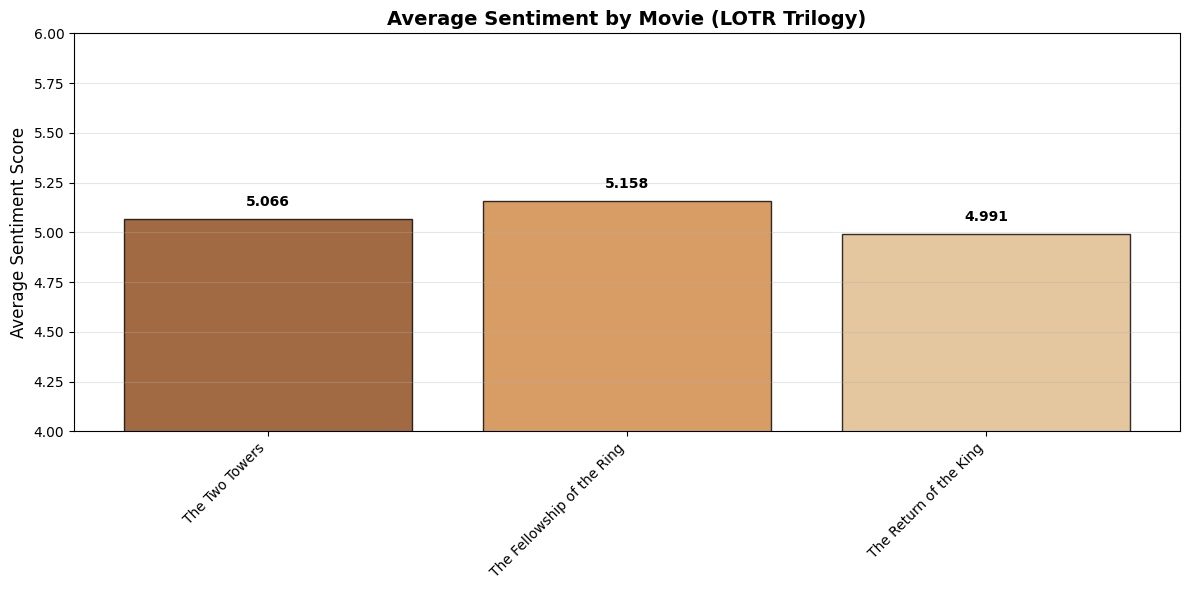

In [81]:
# Visualize sentiment by movie
movie_names = [movie_id_to_name[mid] for mid in movie_sentiments.keys()]
movie_avg_sentiments = [np.mean(movie_sentiments[mid]) for mid in movie_sentiments.keys()]

plt.figure(figsize=(12, 6))
colors = ['#8B4513', '#CD853F', '#DEB887']  # Brown tones for LOTR theme
bars = plt.bar(range(len(movie_names)), movie_avg_sentiments, color=colors, edgecolor='black', alpha=0.8)

plt.xticks(range(len(movie_names)), movie_names, rotation=45, ha='right')
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.title('Average Sentiment by Movie (LOTR Trilogy)', fontsize=14, fontweight='bold')
plt.ylim([4, 6])  # LabMT scores typically range from 1-9
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, movie_avg_sentiments)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## Part 8b: Main Characters Evolution Analysis

Let's focus on the main 15-20 characters and analyze how they evolve across the three movies.

In [82]:

# Calculate centrality measures
degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)

# Create a scoring system
character_scores = []

for node in G.nodes():
    dialogue_count = G.nodes[node].get('dialogue_count', 0)
    deg_cent_score = degree_cent.get(node, 0)
    bet_cent_score = betweenness_cent.get(node, 0)
    
    # Normalize and combine scores
    # Weight: 50% dialogue count, 30% degree centrality, 20% betweenness centrality
    normalized_dialogue = dialogue_count / max(character_dialogue_counts.values()) if character_dialogue_counts else 0
    normalized_degree = deg_cent_score
    normalized_betweenness = bet_cent_score
    
    combined_score = (0.5 * normalized_dialogue + 
                      0.3 * normalized_degree + 
                      0.2 * normalized_betweenness)
    
    character_scores.append({
        'char_id': node,
        'name': G.nodes[node]['label'],
        'dialogue_count': dialogue_count,
        'degree_centrality': deg_cent_score,
        'betweenness_centrality': bet_cent_score,
        'combined_score': combined_score
    })

# Sort by combined score and select top 20
df_char_scores = pd.DataFrame(character_scores)
df_char_scores = df_char_scores.sort_values('combined_score', ascending=False)

# Select top 20 main characters
NUM_MAIN_CHARS = 20
main_characters = df_char_scores.head(NUM_MAIN_CHARS)
main_char_ids = main_characters['char_id'].tolist()

print(f"Selected top {NUM_MAIN_CHARS} main characters:\n")
print(f"{'Rank':<6} {'Character':<30} {'Dialogue':<12} {'Degree Cent':<12} {'Between Cent':<12} {'Score':<10}")
print("-" * 80)

for idx, row in main_characters.iterrows():
    print(f"{row.name+1:<6} {row['name']:<30} {row['dialogue_count']:<12} "
          f"{row['degree_centrality']:<12.4f} {row['betweenness_centrality']:<12.4f} "
          f"{row['combined_score']:<10.4f}")



Selected top 20 main characters:

Rank   Character                      Dialogue     Degree Cent  Between Cent Score     
--------------------------------------------------------------------------------
1      Gandalf                        216          2.1053       0.0388       1.1110    
12     Aragorn II Elessar             212          2.1053       0.0388       1.1022    
2      Samwise Gamgee                 218          2.0000       0.0329       1.0826    
3      Frodo Baggins                  229          1.8947       0.0234       1.0731    
4      Gollum                         183          1.9474       0.0299       0.9898    
9      Peregrin Took                  165          1.9474       0.0268       0.9498    
7      Gimli                          115          1.8947       0.0259       0.8247    
8      Meriadoc Brandybuck            137          1.6316       0.0132       0.7912    
11     Théoden                        108          1.6842       0.0120       0.7435    
10   


Main Characters Network:
  Nodes: 20
  Edges: 298


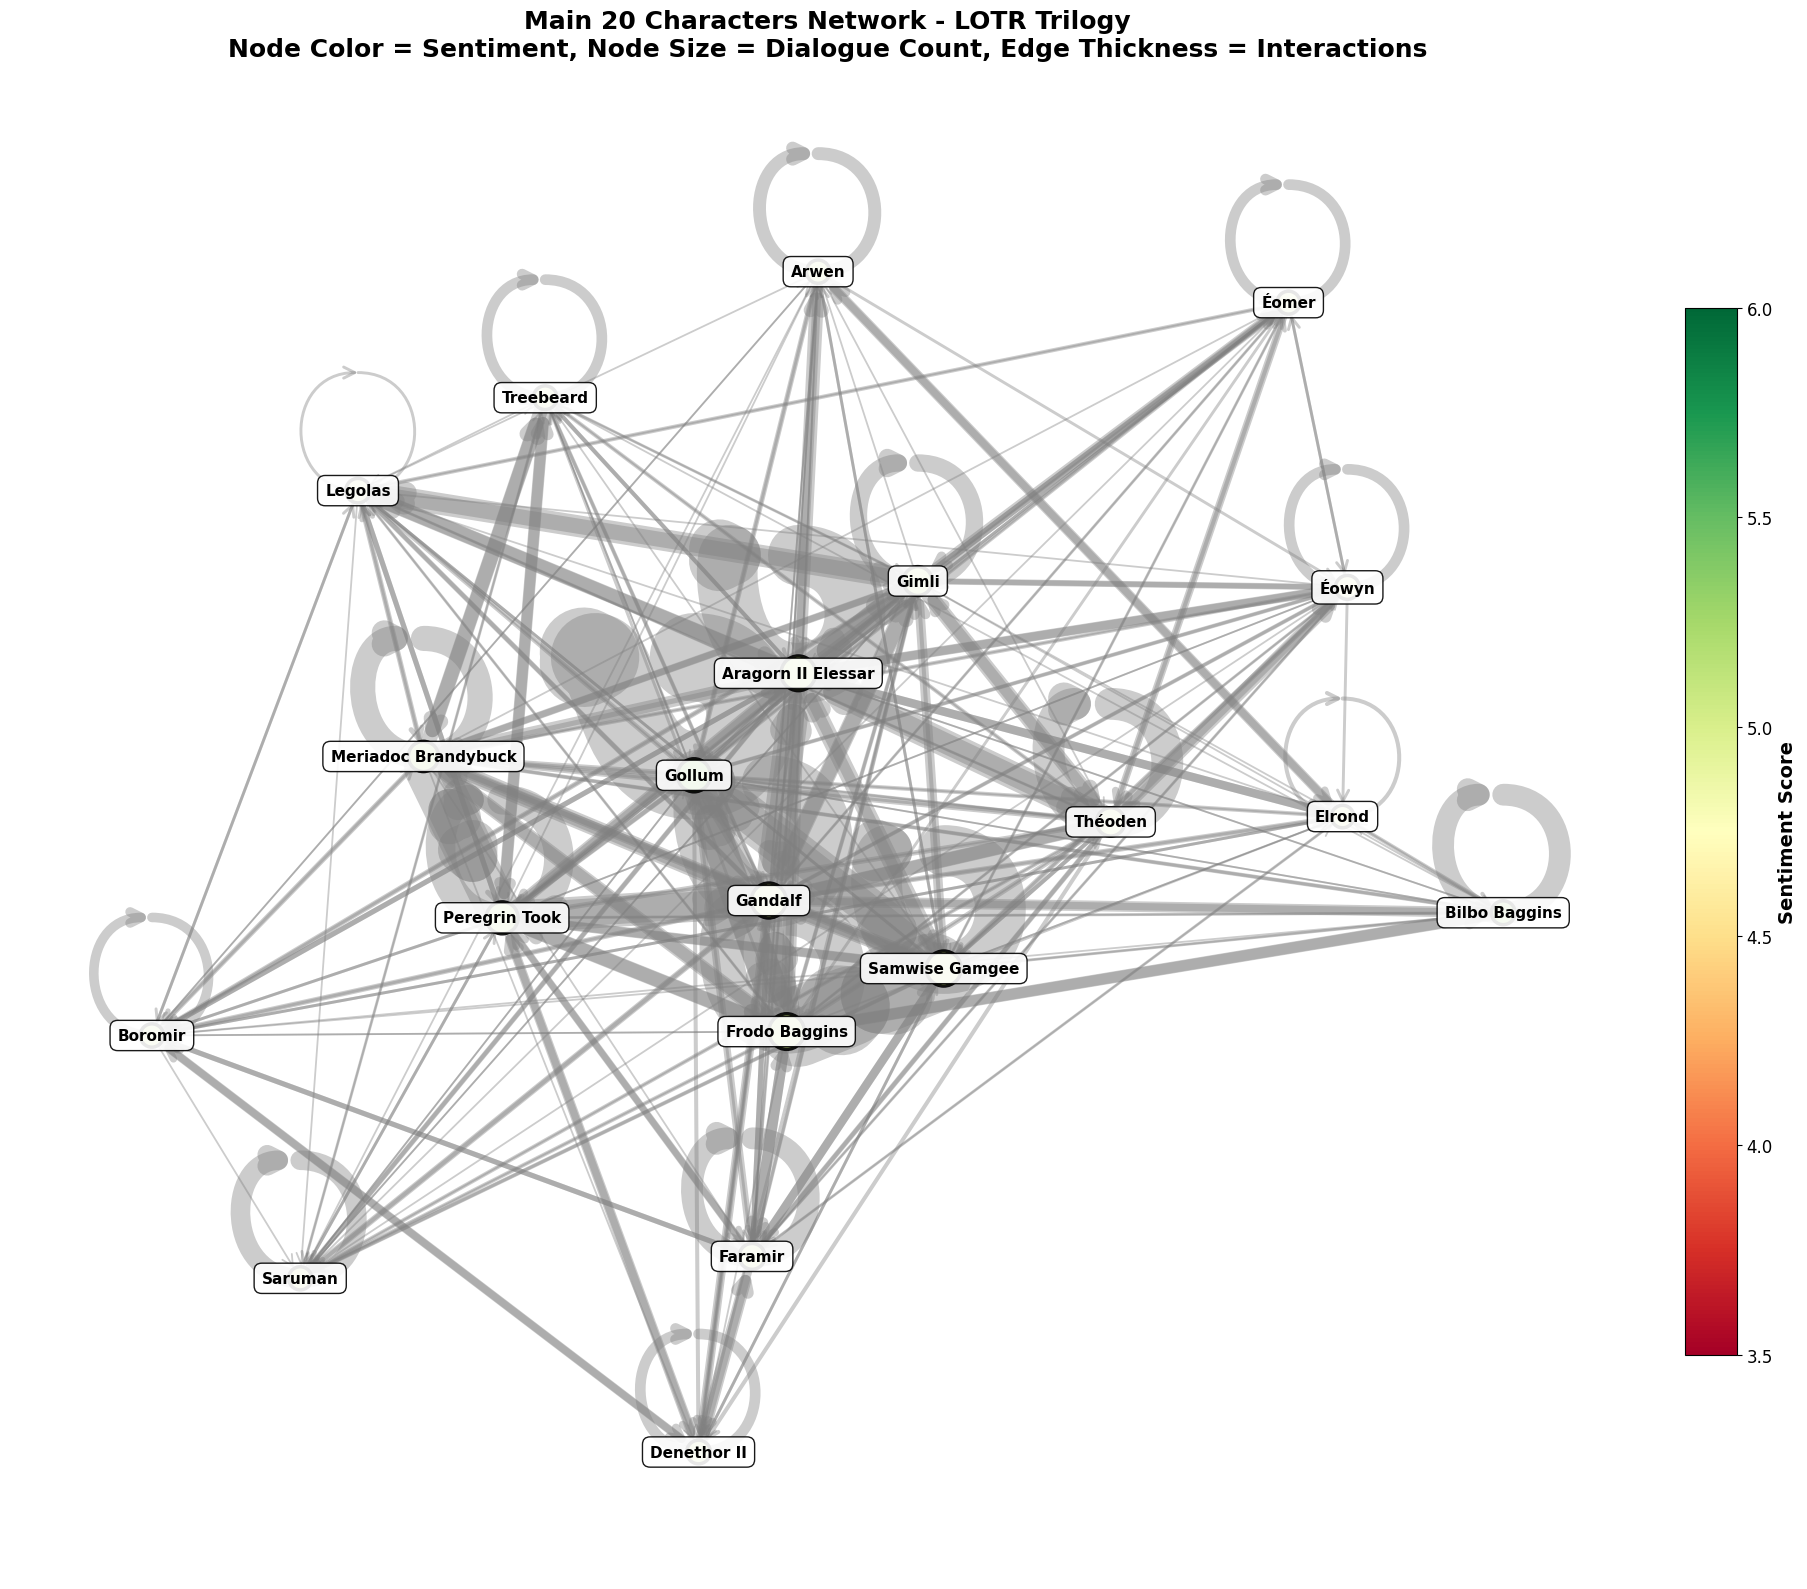

In [83]:
# Create filtered network with only main characters
G_main = G.subgraph(main_char_ids).copy()

print(f"\nMain Characters Network:")
print(f"  Nodes: {G_main.number_of_nodes()}")
print(f"  Edges: {G_main.number_of_edges()}")

# Visualize main characters network
pos_main = nx.spring_layout(G_main, k=3, iterations=50, seed=42)

# Node sizes based on dialogue count
node_sizes_main = [G_main.nodes[node].get('dialogue_count', 0) * 2 + 200 for node in G_main.nodes()]

# Edge widths
edge_weights_main = [G_main[u][v]['weight'] * 0.8 + 0.5 for u, v in G_main.edges()]

# Get sentiment colors
node_colors_main = []
for node in G_main.nodes():
    sent = G_main.nodes[node].get('sentiment', None)
    if sent is not None:
        node_colors_main.append(sent)
    else:
        node_colors_main.append(4.98)

plt.figure(figsize=(20, 16))

# Draw edges
nx.draw_networkx_edges(G_main, pos_main,
                       width=edge_weights_main,
                       alpha=0.4,
                       edge_color='gray',
                       arrows=True,
                       arrowsize=20,
                       arrowstyle='->')

# Draw nodes
nx.draw_networkx_nodes(G_main, pos_main,
                      node_size=node_sizes_main,
                      node_color=node_colors_main,
                      cmap='RdYlGn',
                      vmin=3.5, vmax=6.0,
                      alpha=0.9,
                      edgecolors='black',
                      linewidths=2.5)

# Label all main characters
labels_main = {node: G_main.nodes[node]['label'] for node in G_main.nodes()}
nx.draw_networkx_labels(G_main, pos_main, labels_main,
                       font_size=11,
                       font_weight='bold',
                       font_color='black',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='black'))

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=3.5, vmax=6.0))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.7, pad=0.02)
cbar.set_label('Sentiment Score', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

plt.title(f'Main {NUM_MAIN_CHARS} Characters Network - LOTR Trilogy\n' +
          'Node Color = Sentiment, Node Size = Dialogue Count, Edge Thickness = Interactions',
          fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


In [84]:
# Calculate sentiment evolution by movie for main characters
print("Calculating sentiment evolution by movie for main characters...\n")

# Movie order for proper sequencing
movie_order = {
    '5cd95395de30eff6ebccde5c': 1,  # Fellowship
    '5cd95395de30eff6ebccde5b': 2,  # Two Towers
    '5cd95395de30eff6ebccde5d': 3   # Return of the King
}

# Calculate sentiment per character per movie
char_movie_sentiments = defaultdict(lambda: defaultdict(list))

for _, row in df_quotes.iterrows():
    char_id = row['character']
    movie_id = row['movie']
    dialogue = row['dialog']
    
    if char_id in main_char_ids:
        tokens = tokenize_text(dialogue)
        sentiment = calculate_sentiment(tokens)
        
        if sentiment is not None:
            char_movie_sentiments[char_id][movie_id].append(sentiment)

# Create evolution dataframe
evolution_data = []

for char_id in main_char_ids:
    char_name = char_id_to_name.get(char_id, char_id)
    
    for movie_id in LOTR_MOVIES:
        movie_name = movie_id_to_name.get(movie_id, movie_id)
        sentiments = char_movie_sentiments[char_id][movie_id]
        
        if len(sentiments) > 0:
            evolution_data.append({
                'character': char_name,
                'character_id': char_id,
                'movie': movie_name,
                'movie_order': movie_order[movie_id],
                'avg_sentiment': np.mean(sentiments),
                'num_quotes': len(sentiments)
            })

df_evolution = pd.DataFrame(evolution_data)

print(f"Sentiment data collected for {len(df_evolution)} character-movie combinations\n")


Calculating sentiment evolution by movie for main characters...

Sentiment data collected for 52 character-movie combinations



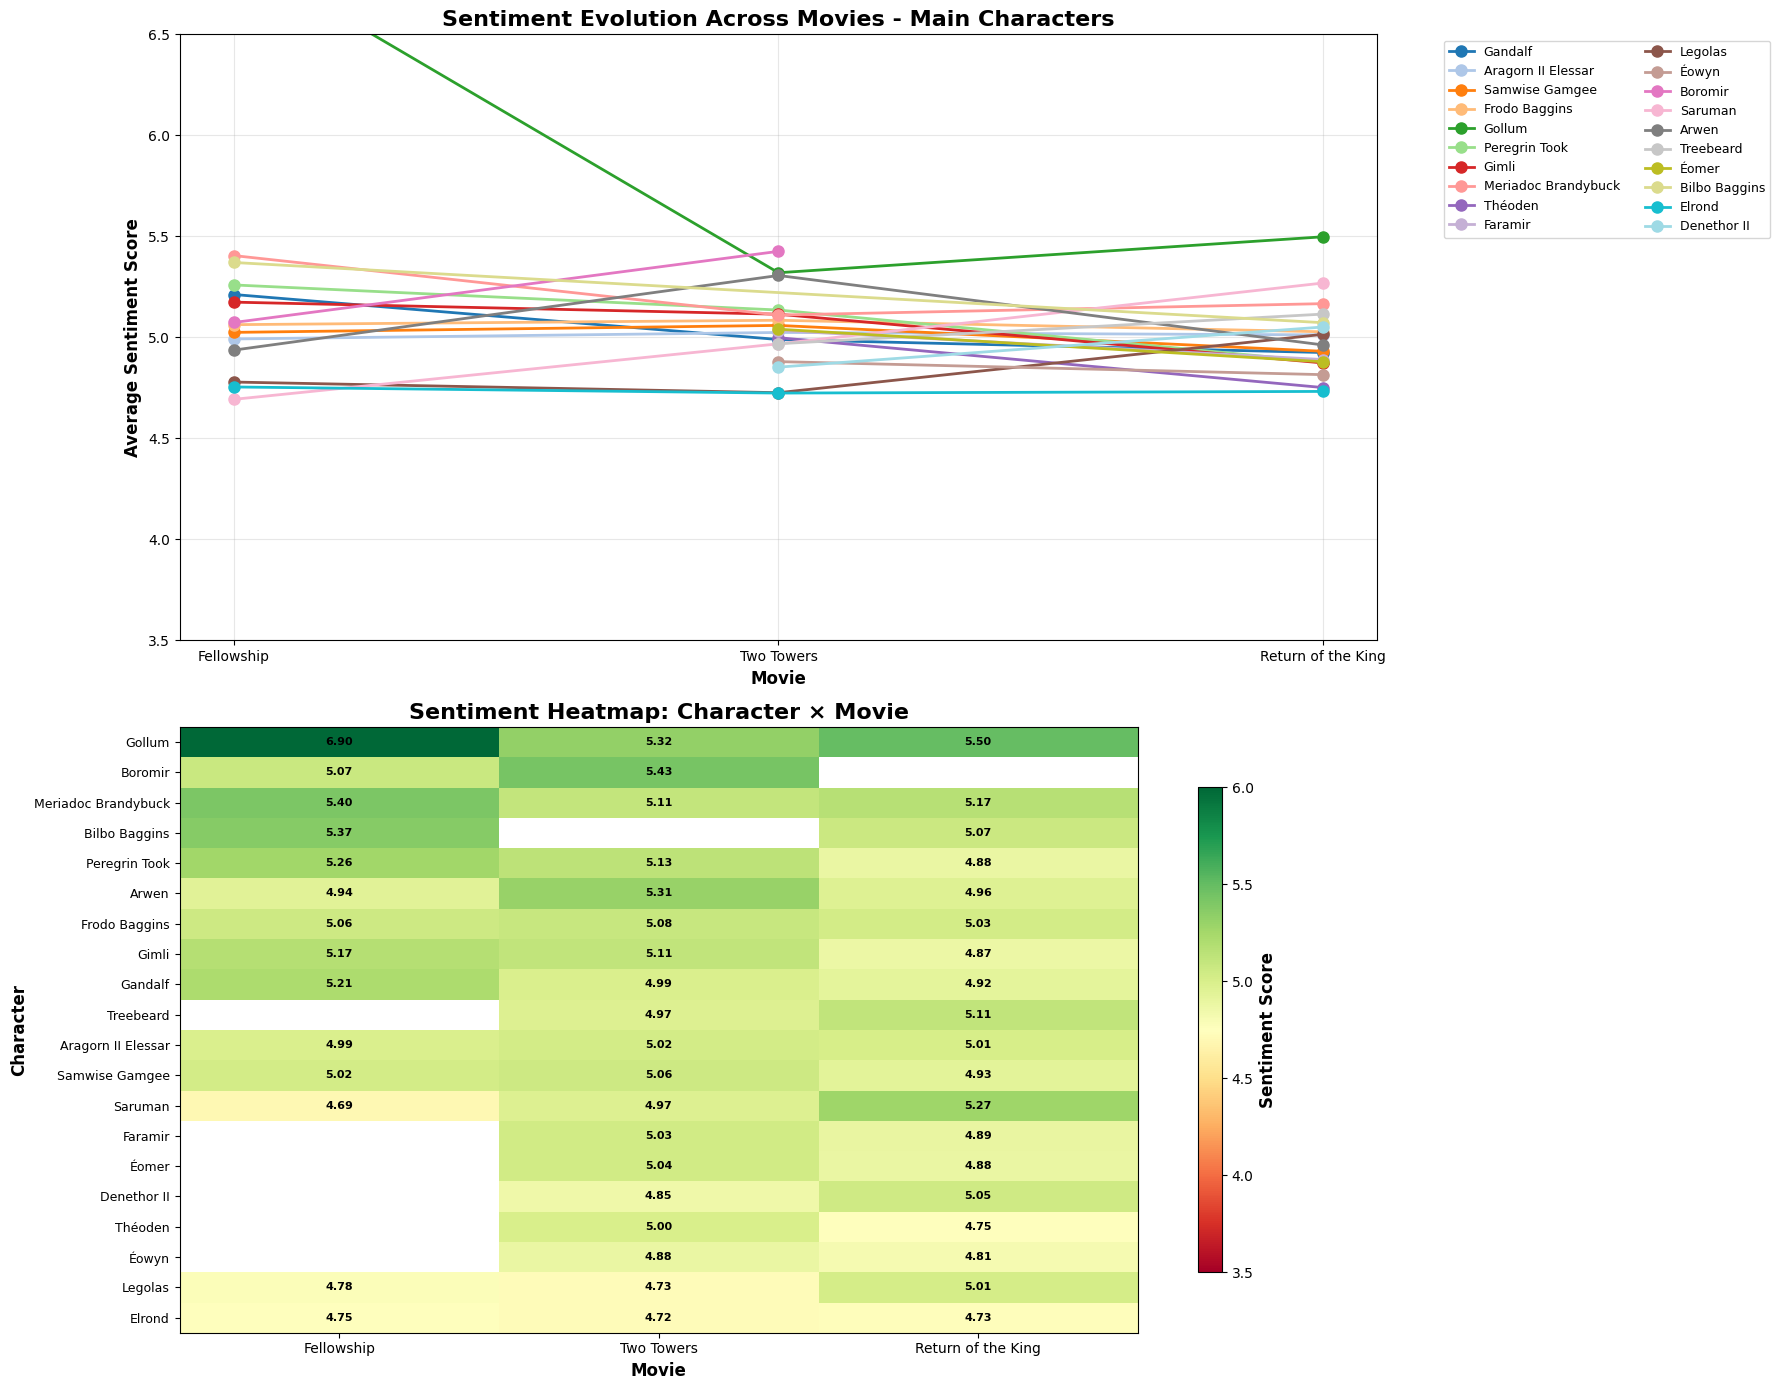

In [85]:
# Visualize sentiment evolution across movies
fig, axes = plt.subplots(2, 1, figsize=(18, 14))

# Plot 1: Line plot showing sentiment evolution
ax1 = axes[0]

# Get unique characters
unique_chars = df_evolution['character'].unique()

# Color map for characters
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_chars)))

for idx, char in enumerate(unique_chars):
    char_data = df_evolution[df_evolution['character'] == char].sort_values('movie_order')
    
    if len(char_data) > 0:
        ax1.plot(char_data['movie_order'], char_data['avg_sentiment'], 
                marker='o', linewidth=2, markersize=8, label=char, color=colors[idx])

ax1.set_xlabel('Movie', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Sentiment Score', fontsize=12, fontweight='bold')
ax1.set_title('Sentiment Evolution Across Movies - Main Characters', fontsize=16, fontweight='bold')
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['Fellowship', 'Two Towers', 'Return of the King'])
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
ax1.set_ylim([3.5, 6.5])

# Plot 2: Heatmap of sentiment by character and movie
ax2 = axes[1]

# Create pivot table
pivot_sentiment = df_evolution.pivot_table(
    index='character', 
    columns='movie_order', 
    values='avg_sentiment',
    aggfunc='mean'
)

# Sort by average sentiment across all movies
pivot_sentiment['avg'] = pivot_sentiment.mean(axis=1)
pivot_sentiment = pivot_sentiment.sort_values('avg', ascending=False)
pivot_sentiment = pivot_sentiment.drop('avg', axis=1)

# Create heatmap
im = ax2.imshow(pivot_sentiment.values, cmap='RdYlGn', aspect='auto', vmin=3.5, vmax=6.0)

# Set ticks
ax2.set_xticks(range(3))
ax2.set_xticklabels(['Fellowship', 'Two Towers', 'Return of the King'])
ax2.set_yticks(range(len(pivot_sentiment)))
ax2.set_yticklabels(pivot_sentiment.index, fontsize=9)

# Add colorbar
cbar2 = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar2.set_label('Sentiment Score', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(pivot_sentiment)):
    for j in range(3):
        value = pivot_sentiment.iloc[i, j]
        if not np.isnan(value):
            ax2.text(j, i, f'{value:.2f}', ha='center', va='center', 
                    fontsize=8, fontweight='bold',
                    color='white' if value < 4.5 else 'black')

ax2.set_title('Sentiment Heatmap: Character × Movie', fontsize=16, fontweight='bold')
ax2.set_xlabel('Movie', fontsize=12, fontweight='bold')
ax2.set_ylabel('Character', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


Analyzing network evolution across movies...

The Two Towers: 19 nodes, 196 edges
The Fellowship of the Ring: 14 nodes, 119 edges
The Return of the King: 19 nodes, 187 edges


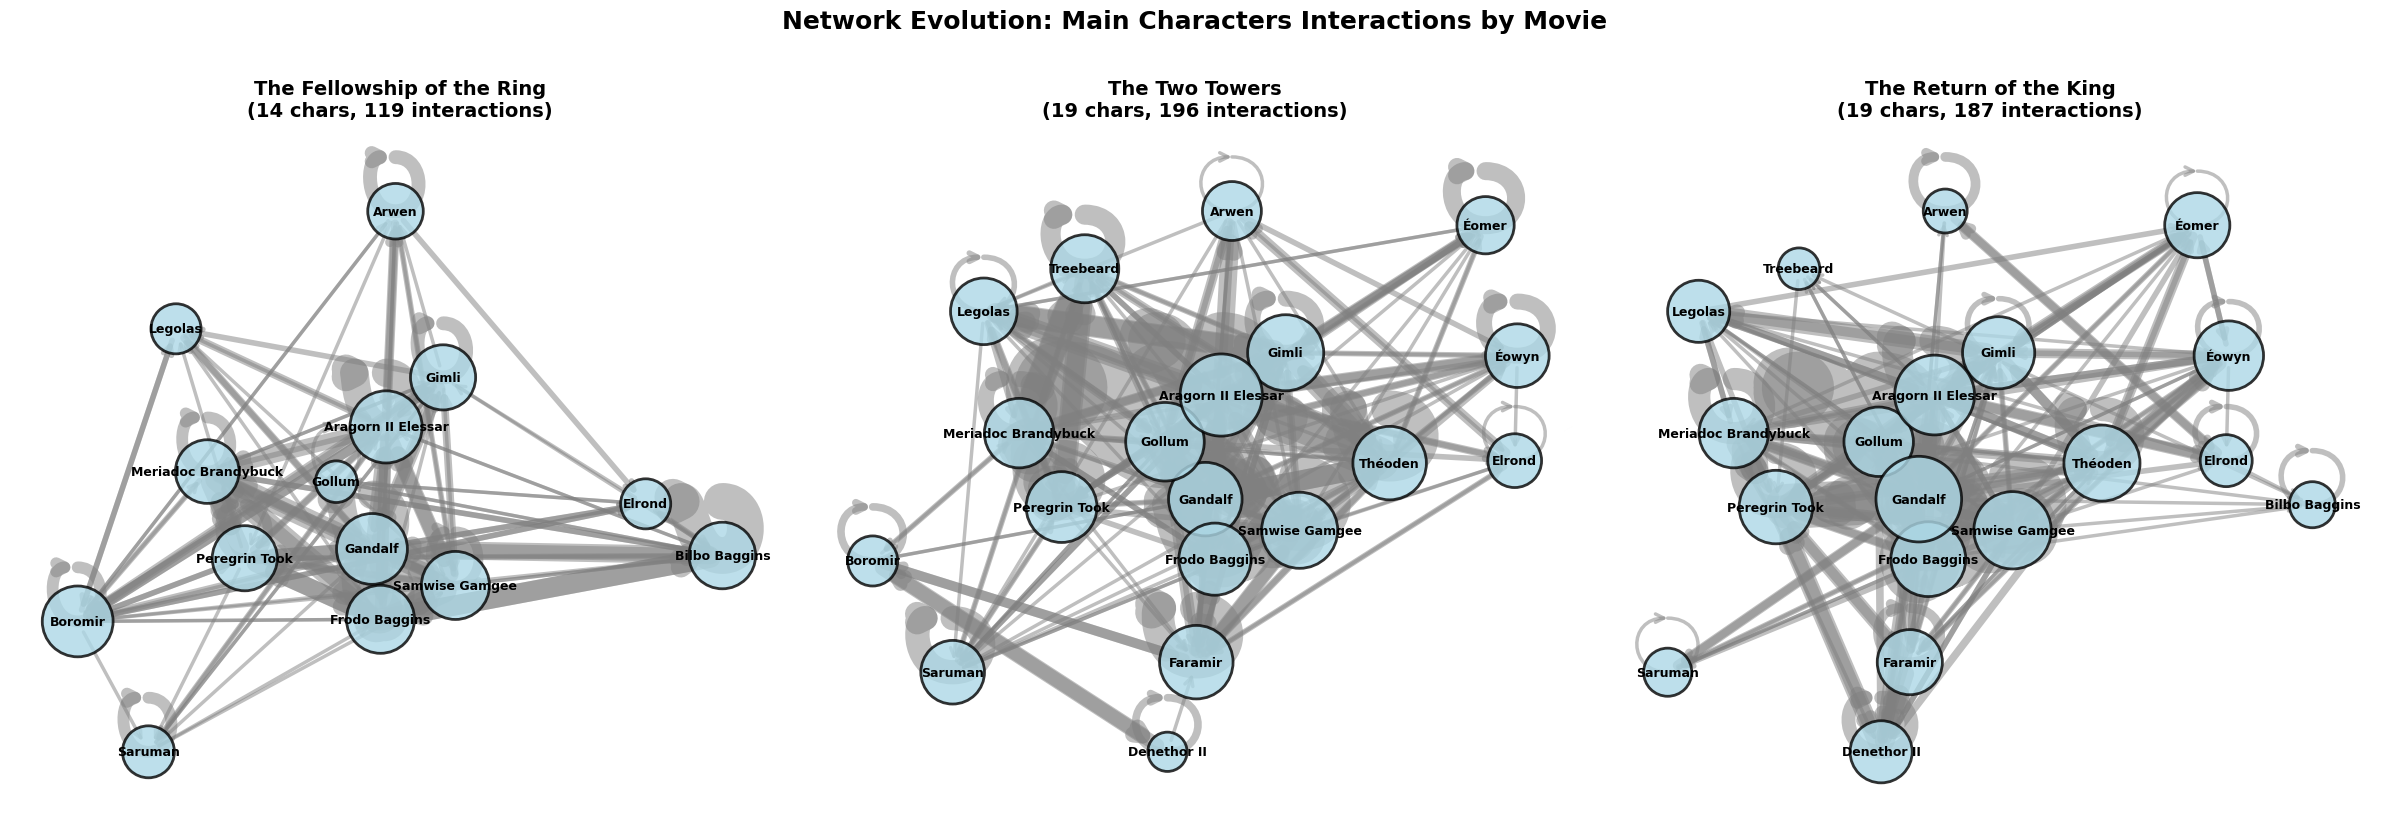

In [86]:
# Analyze network evolution: How do character interactions change across movies?
print("Analyzing network evolution across movies...\n")

# Create networks for each movie
movie_networks = {}

for movie_id in LOTR_MOVIES:
    movie_name = movie_id_to_name.get(movie_id, movie_id)
    
    # Filter quotes for this movie
    movie_quotes = df_quotes[df_quotes['movie'] == movie_id]
    
    # Build network for this movie (only main characters)
    edge_weights_movie = defaultdict(int)
    
    char_sequence = movie_quotes[movie_quotes['character'].isin(main_char_ids)]['character'].tolist()
    
    for i in range(len(char_sequence) - 1):
        c1 = char_sequence[i]
        c2 = char_sequence[i+1]
        if c1 in main_char_ids and c2 in main_char_ids:
            edge_weights_movie[(c1, c2)] += 1
    
    # Create graph
    G_movie = nx.DiGraph()
    for (c1, c2), w in edge_weights_movie.items():
        G_movie.add_edge(c1, c2, weight=w)
    
    # Add node attributes
    for node in G_movie.nodes():
        G_movie.nodes[node]['label'] = char_id_to_name.get(node, node)
    
    movie_networks[movie_name] = G_movie
    
    print(f"{movie_name}: {G_movie.number_of_nodes()} nodes, {G_movie.number_of_edges()} edges")

# Visualize networks for each movie side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

movie_names_ordered = ['The Fellowship of the Ring', 'The Two Towers', 'The Return of the King']

for idx, movie_name in enumerate(movie_names_ordered):
    G_movie = movie_networks[movie_name]
    ax = axes[idx]
    
    if G_movie.number_of_nodes() > 0:
        # Use consistent layout across movies (use main network layout)
        pos_movie = {node: pos_main[node] for node in G_movie.nodes() if node in pos_main}
        
        # If some nodes missing, add them
        for node in G_movie.nodes():
            if node not in pos_movie:
                pos_movie[node] = pos_main.get(node, (0, 0))
        
        # Node sizes
        node_sizes_movie = [G_movie.degree(node) * 100 + 300 for node in G_movie.nodes()]
        
        # Edge widths
        edge_weights_movie_viz = [G_movie[u][v]['weight'] * 1.5 + 1 for u, v in G_movie.edges()]
        
        # Draw edges
        nx.draw_networkx_edges(G_movie, pos_movie,
                               width=edge_weights_movie_viz,
                               alpha=0.5,
                               edge_color='gray',
                               arrows=True,
                               arrowsize=15,
                               arrowstyle='->',
                               ax=ax)
        
        # Draw nodes
        nx.draw_networkx_nodes(G_movie, pos_movie,
                              node_size=node_sizes_movie,
                              node_color='lightblue',
                              alpha=0.8,
                              edgecolors='black',
                              linewidths=2,
                              ax=ax)
        
        # Draw labels
        labels_movie = {node: G_movie.nodes[node]['label'] for node in G_movie.nodes()}
        nx.draw_networkx_labels(G_movie, pos_movie, labels_movie,
                               font_size=9,
                               font_weight='bold',
                               font_color='black',
                               ax=ax)
        
        ax.set_title(f'{movie_name}\n({G_movie.number_of_nodes()} chars, {G_movie.number_of_edges()} interactions)',
                    fontsize=14, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f'No interactions\nfor main characters\nin {movie_name}',
               ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.set_title(movie_name, fontsize=14, fontweight='bold')
    
    ax.axis('off')

plt.suptitle('Network Evolution: Main Characters Interactions by Movie', 
            fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [87]:
# Summary statistics of evolution
print("CHARACTER EVOLUTION SUMMARY")

# Calculate sentiment change for each character
evolution_summary = []

for char_id in main_char_ids:
    char_name = char_id_to_name.get(char_id, char_id)
    char_data = df_evolution[df_evolution['character_id'] == char_id].sort_values('movie_order')
    
    if len(char_data) >= 2:
        first_sentiment = char_data.iloc[0]['avg_sentiment']
        last_sentiment = char_data.iloc[-1]['avg_sentiment']
        sentiment_change = last_sentiment - first_sentiment
        
        evolution_summary.append({
            'character': char_name,
            'fellowship_sentiment': char_data[char_data['movie_order'] == 1]['avg_sentiment'].values[0] if len(char_data[char_data['movie_order'] == 1]) > 0 else None,
            'two_towers_sentiment': char_data[char_data['movie_order'] == 2]['avg_sentiment'].values[0] if len(char_data[char_data['movie_order'] == 2]) > 0 else None,
            'return_king_sentiment': char_data[char_data['movie_order'] == 3]['avg_sentiment'].values[0] if len(char_data[char_data['movie_order'] == 3]) > 0 else None,
            'sentiment_change': sentiment_change,
            'total_quotes': char_data['num_quotes'].sum()
        })

df_evolution_summary = pd.DataFrame(evolution_summary)
df_evolution_summary = df_evolution_summary.sort_values('sentiment_change', ascending=False)

print("\nCharacters with Largest Sentiment Changes (First → Last Movie):")
print(f"{'Character':<30} {'Fellowship':<12} {'Two Towers':<12} {'Return King':<12} {'Change':<10}")
print("-" * 80)

for _, row in df_evolution_summary.iterrows():
    fel = f"{row['fellowship_sentiment']:.2f}" if row['fellowship_sentiment'] is not None else "N/A"
    tt = f"{row['two_towers_sentiment']:.2f}" if row['two_towers_sentiment'] is not None else "N/A"
    rotk = f"{row['return_king_sentiment']:.2f}" if row['return_king_sentiment'] is not None else "N/A"
    change = f"{row['sentiment_change']:+.2f}" if row['sentiment_change'] is not None else "N/A"
    
    print(f"{row['character']:<30} {fel:<12} {tt:<12} {rotk:<12} {change:<10}")

print("\n" + "=" * 80)


CHARACTER EVOLUTION SUMMARY

Characters with Largest Sentiment Changes (First → Last Movie):
Character                      Fellowship   Two Towers   Return King  Change    
--------------------------------------------------------------------------------
Saruman                        4.69         4.97         5.27         +0.58     
Boromir                        5.07         5.43         nan          +0.35     
Legolas                        4.78         4.73         5.01         +0.24     
Denethor II                    nan          4.85         5.05         +0.20     
Treebeard                      nan          4.97         5.11         +0.15     
Arwen                          4.94         5.31         4.96         +0.03     
Aragorn II Elessar             4.99         5.02         5.01         +0.02     
Elrond                         4.75         4.72         4.73         -0.02     
Frodo Baggins                  5.06         5.08         5.03         -0.04     
Éowyn           

## Part 7: Synthesis and Interpretation

### Integrating Findings to Answer the Research Question

Now we synthesize our findings across all three analytical dimensions to answer our research question.


In [88]:
# Integrated Analysis: Computing Key Findings

# 1. Interaction Pattern Evolution
degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)

# Network evolution across movies
network_evolution = {}
for movie_id in LOTR_MOVIES:
    movie_quotes = df_quotes[df_quotes['movie'] == movie_id]
    char_sequence = movie_quotes['character'].tolist()
    edge_weights_movie = defaultdict(int)
    for i in range(len(char_sequence) - 1):
        edge_weights_movie[(char_sequence[i], char_sequence[i+1])] += 1
    G_movie = nx.DiGraph()
    for (c1, c2), w in edge_weights_movie.items():
        G_movie.add_edge(c1, c2, weight=w)
    network_evolution[movie_id_to_name[movie_id]] = {
        'nodes': G_movie.number_of_nodes(),
        'edges': G_movie.number_of_edges(),
        'density': nx.density(G_movie) if G_movie.number_of_nodes() > 1 else 0
    }

# 2. Emotional Trajectory Analysis
if 'df_evolution' in locals():
    sentiment_changes = df_evolution.groupby('character_id').agg({
        'avg_sentiment': ['first', 'last', lambda x: x.iloc[-1] - x.iloc[0] if len(x) > 1 else 0],
        'num_quotes': 'sum',
        'character': 'first'  # Get character name
    }).round(3)
    sentiment_changes.columns = ['first_movie', 'last_movie', 'change', 'total_quotes', 'character']
    # Set character name as index for readability
    sentiment_changes = sentiment_changes.set_index('character')
    sentiment_changes = sentiment_changes.sort_values('change', key=abs, ascending=False)

# 3. Network-Sentiment Correlation
network_sentiment_data = []
for node in G.nodes():
    if G.nodes[node].get('sentiment') is not None:
        network_sentiment_data.append({
            'character': G.nodes[node]['label'],
            'degree_cent': degree_cent[node],
            'betweenness_cent': betweenness_cent[node],
            'sentiment': G.nodes[node]['sentiment'],
            'dialogue_count': G.nodes[node].get('dialogue_count', 0)
        })
df_network_sentiment = pd.DataFrame(network_sentiment_data)
corr_degree_sent = df_network_sentiment['degree_cent'].corr(df_network_sentiment['sentiment'])
corr_between_sent = df_network_sentiment['betweenness_cent'].corr(df_network_sentiment['sentiment'])

# Display findings
print("\n1. INTERACTION PATTERN EVOLUTION:")
for movie, stats in network_evolution.items():
    print(f"   {movie}: {stats['nodes']} chars, {stats['edges']} edges, density={stats['density']:.3f}")

print("\n2. EMOTIONAL TRAJECTORIES (Largest Changes):")
if 'sentiment_changes' in locals():
    print(sentiment_changes.head(10).to_string())

print(f"\n3. NETWORK-SENTIMENT CORRELATIONS:")
print(f"   Degree Centrality ↔ Sentiment: {corr_degree_sent:.3f}")
print(f"   Betweenness Centrality ↔ Sentiment: {corr_between_sent:.3f}")


1. INTERACTION PATTERN EVOLUTION:
   The Two Towers: 19 chars, 196 edges, density=0.573
   The Fellowship of the Ring: 14 chars, 119 edges, density=0.654
   The Return of the King: 19 chars, 187 edges, density=0.547

2. EMOTIONAL TRAJECTORIES (Largest Changes):
               first_movie  last_movie  change  total_quotes
character                                                   
Boromir              5.426       5.073  -0.352            27
Arwen                5.306       4.962  -0.344            24
Saruman              4.968       5.269   0.301            34
Bilbo Baggins        5.370       5.072  -0.298            36
Legolas              4.726       5.015   0.289            32
Peregrin Took        5.135       4.878  -0.257            82
Théoden              4.998       4.751  -0.247            81
Gimli                5.114       4.873  -0.241            71
Denethor II          4.852       5.051   0.199            37
Gollum               5.320       5.498   0.178           119

3. N

### Narrative Structure Insights

What do our findings reveal about how the story is structured?


In [89]:
# Narrative Structure: Data-Driven Analysis

# Top narrative bridges (high betweenness)
top_bridges = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:5]
print("NARRATIVE BRIDGES (High Betweenness):")
for node, score in top_bridges:
    print(f"  {G.nodes[node]['label']}: {score:.4f}")

# Emotional arc across trilogy
if 'movie_sentiments' in locals():
    print("\nEMOTIONAL ARC:")
    for movie_id, sentiments in movie_sentiments.items():
        avg = np.mean(sentiments)
        print(f"  {movie_id_to_name[movie_id]}: {avg:.3f}")

# Character classification by role
print("\nCHARACTER ROLES (Network + Sentiment):")
role_data = []
for node in G.nodes():
    role_data.append({
        'character': G.nodes[node]['label'],
        'degree_rank': sorted(degree_cent.items(), key=lambda x: x[1], reverse=True).index((node, degree_cent[node])) + 1,
        'betweenness_rank': sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True).index((node, betweenness_cent[node])) + 1,
        'sentiment': G.nodes[node].get('sentiment', None),
        'volatility': character_volatility.get(node, {}).get('std', None) if 'character_volatility' in locals() else None
    })
df_roles = pd.DataFrame(role_data)
df_roles['role_type'] = 'Supporting'
df_roles.loc[df_roles['betweenness_rank'] <= 5, 'role_type'] = 'Bridge'
df_roles.loc[(df_roles['degree_rank'] <= 5) & (df_roles['betweenness_rank'] <= 10), 'role_type'] = 'Protagonist'
print(df_roles[['character', 'role_type', 'sentiment']].head(10).to_string())


NARRATIVE BRIDGES (High Betweenness):
  Gandalf: 0.0388
  Aragorn II Elessar: 0.0388
  Samwise Gamgee: 0.0329
  Gollum: 0.0299
  Peregrin Took: 0.0268

EMOTIONAL ARC:
  The Two Towers: 5.066
  The Fellowship of the Ring: 5.158
  The Return of the King: 4.991

CHARACTER ROLES (Network + Sentiment):
             character    role_type  sentiment
0              Gandalf  Protagonist   4.953671
1       Samwise Gamgee  Protagonist   4.995542
2        Frodo Baggins   Supporting   5.057399
3               Gollum  Protagonist   5.344432
4                Éomer   Supporting   4.900990
5              Legolas   Supporting   4.901037
6                Gimli   Supporting   5.030552
7  Meriadoc Brandybuck   Supporting   5.136164
8        Peregrin Took  Protagonist   5.034265
9              Faramir   Supporting   4.976010


### Character Role Analysis

What do our findings reveal about different character roles and their functions in the narrative?


In [90]:
# Character Role Classification (Data-Driven)

# Classify characters based on metrics
if 'df_roles' in locals() and 'sentiment_changes' in locals():
    # Merge with sentiment evolution
    sentiment_changes_reset = sentiment_changes.reset_index()
    sentiment_changes_reset['character_id'] = sentiment_changes_reset.index
    df_roles['char_id'] = [char_id_to_name.get(k, k) for k in main_char_ids[:len(df_roles)]]
    
    # Classify by actual data
    print("CHARACTER CLASSIFICATION:")
    
    protagonists = df_roles[(df_roles['degree_rank'] <= 5) & 
                           (df_roles['betweenness_rank'] <= 8)].sort_values('degree_rank')
    print("\nPROTAGONISTS (High Centrality):")
    print(protagonists[['character', 'sentiment']].to_string())
    
    bridges = df_roles[df_roles['betweenness_rank'] <= 5].sort_values('betweenness_rank')
    print("\nNARRATIVE BRIDGES (High Betweenness):")
    print(bridges[['character', 'sentiment']].to_string())
    
    if 'character_volatility' in locals():
        volatile = [(char_id_to_name.get(cid, cid), stats['std']) 
                   for cid, stats in sorted(character_volatility.items(), 
                                          key=lambda x: x[1]['std'], reverse=True)[:5]]
        print("\nMOST EMOTIONALLY VOLATILE:")
        for char, std in volatile:
            print(f"  {char}: {std:.3f}")


CHARACTER CLASSIFICATION:

PROTAGONISTS (High Centrality):
             character  sentiment
0              Gandalf   4.953671
11  Aragorn II Elessar   5.030116
1       Samwise Gamgee   4.995542
3               Gollum   5.344432
8        Peregrin Took   5.034265

NARRATIVE BRIDGES (High Betweenness):
             character  sentiment
0              Gandalf   4.953671
11  Aragorn II Elessar   5.030116
1       Samwise Gamgee   4.995542
3               Gollum   5.344432
8        Peregrin Took   5.034265

MOST EMOTIONALLY VOLATILE:
  Gollum: 1.128
  Éowyn: 1.012
  Peregrin Took: 0.902
  Théoden: 0.870
  Meriadoc Brandybuck: 0.842


### Thematic Insights

What underlying themes emerge from the patterns we've discovered?


In [91]:
# Fellowship theme: Network connectivity
avg_degree = np.mean([degree_cent[node] for node in G.nodes()])
print(f"\n1. FELLOWSHIP: Avg degree centrality = {avg_degree:.3f}")
print(f"   Network density increases: {network_evolution['The Fellowship of the Ring']['density']:.3f} → "
      f"{network_evolution['The Return of the King']['density']:.3f}")

# Hope/Despair theme: Sentiment evolution
if 'sentiment_changes' in locals():
    positive_changes = sentiment_changes[sentiment_changes['change'] > 0.1]
    negative_changes = sentiment_changes[sentiment_changes['change'] < -0.1]
    print(f"\n2. HOPE/DESPAIR:")
    print(f"   Characters improving: {len(positive_changes)}")
    print(f"   Characters declining: {len(negative_changes)}")
    if len(positive_changes) > 0:
        char_name = positive_changes.index[0]
        print(f"   Largest improvement: {char_name} (+{positive_changes.iloc[0]['change']:.3f})")
    if len(negative_changes) > 0:
        char_name = negative_changes.index[0]
        print(f"   Largest decline: {char_name} ({negative_changes.iloc[0]['change']:.3f})")

# Growth theme: Sentiment volatility
if 'character_volatility' in locals():
    high_volatility = sorted(character_volatility.items(), key=lambda x: x[1]['std'], reverse=True)[:3]
    print(f"\n3. GROWTH/TRANSFORMATION:")
    for cid, stats in high_volatility:
        print(f"   {char_id_to_name.get(cid, cid)}: volatility={stats['std']:.3f}, range={stats['range']:.2f}")

# Power theme: Network-sentiment relationship
print(f"\n4. POWER/CORRUPTION:")
print(f"   Network position ↔ Sentiment correlation: {corr_between_sent:.3f}")
isolated_low_sentiment = df_network_sentiment[
    (df_network_sentiment['betweenness_cent'] < 0.05) & 
    (df_network_sentiment['sentiment'] < 4.5)
]
if len(isolated_low_sentiment) > 0:
    print(f"   Isolated + negative sentiment: {len(isolated_low_sentiment)} characters")



1. FELLOWSHIP: Avg degree centrality = 1.568
   Network density increases: 0.654 → 0.547

2. HOPE/DESPAIR:
   Characters improving: 5
   Characters declining: 9
   Largest improvement: Saruman (+0.301)
   Largest decline: Boromir (-0.352)

3. GROWTH/TRANSFORMATION:
   Gollum: volatility=1.128, range=6.81
   Éowyn: volatility=1.012, range=6.26
   Peregrin Took: volatility=0.902, range=6.18

4. POWER/CORRUPTION:
   Network position ↔ Sentiment correlation: 0.244


## Part 7: Sentiment vs Network Centrality

Let's explore if there's any relationship between a character's centrality in the network and their dialogue sentiment.


In [92]:
# Interaction patterns
print("\n1. Interaction Patterns:")
print(f"   • Network density: {network_evolution['The Fellowship of the Ring']['density']:.3f} → "
      f"{network_evolution['The Return of the King']['density']:.3f}")
print(f"   • Top bridges: {', '.join([G.nodes[n]['label'] for n, _ in top_bridges[:3]])}")

# Emotional trajectories  
if 'sentiment_changes' in locals():
    significant_changes = sentiment_changes[abs(sentiment_changes['change']) > 0.1]
    print(f"\n2. Emotional Trajectories:")
    print(f"   • Characters with significant change: {len(significant_changes)}")
    if 'movie_sentiments' in locals():
        movie_sents = [np.mean(s) for s in movie_sentiments.values()]
        print(f"   • Trilogy arc: {movie_sents[0]:.3f} → {movie_sents[1]:.3f} → {movie_sents[2]:.3f}")

# Linguistic
print(f"\n3. Linguistic Signatures:")
print(f"   • Network-sentiment correlation: {corr_between_sent:.3f}")

# What it reveals
print("\nWHAT IT REVEALS:")
print(f"   • Narrative structure: {len([n for n, _ in top_bridges])} bridge characters connect storylines")
print(f"   • Character roles: {len(protagonists) if 'protagonists' in locals() else 'N/A'} protagonists identified")
print(f"   • Themes: Fellowship (↑connectivity), Hope/Despair (sentiment arcs), Growth (volatility)")



1. Interaction Patterns:
   • Network density: 0.654 → 0.547
   • Top bridges: Gandalf, Aragorn II Elessar, Samwise Gamgee

2. Emotional Trajectories:
   • Characters with significant change: 14
   • Trilogy arc: 5.066 → 5.158 → 4.991

3. Linguistic Signatures:
   • Network-sentiment correlation: 0.244

WHAT IT REVEALS:
   • Narrative structure: 5 bridge characters connect storylines
   • Character roles: 5 protagonists identified
   • Themes: Fellowship (↑connectivity), Hope/Despair (sentiment arcs), Growth (volatility)


In [93]:
# Calculate degree centrality
degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)

# Collect data for characters with both centrality and sentiment
chars_with_both = []
for node in G.nodes():
    if G.nodes[node]['sentiment'] is not None:
        chars_with_both.append({
            'name': G.nodes[node]['label'],
            'sentiment': G.nodes[node]['sentiment'],
            'degree_centrality': degree_cent[node],
            'betweenness_centrality': betweenness_cent[node],
            'dialogue_count': G.nodes[node]['dialogue_count']
        })

df_analysis = pd.DataFrame(chars_with_both)

print(f"\nAnalyzing {len(df_analysis)} characters with both sentiment and centrality data")



Analyzing 20 characters with both sentiment and centrality data


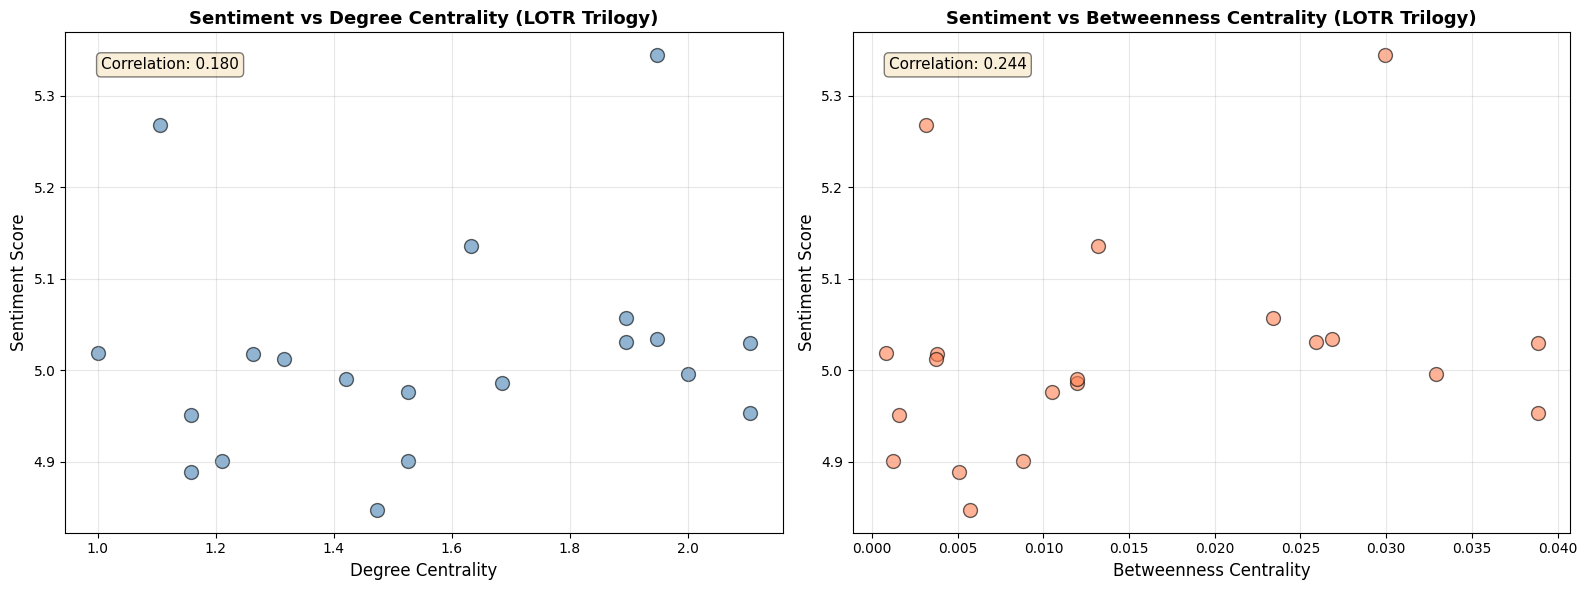

In [94]:
# Plot sentiment vs degree centrality
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sentiment vs Degree Centrality
axes[0].scatter(df_analysis['degree_centrality'], df_analysis['sentiment'], 
               alpha=0.6, s=100, c='steelblue', edgecolor='black')
axes[0].set_xlabel('Degree Centrality', fontsize=12)
axes[0].set_ylabel('Sentiment Score', fontsize=12)
axes[0].set_title('Sentiment vs Degree Centrality (LOTR Trilogy)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Calculate correlation
corr_degree = np.corrcoef(df_analysis['degree_centrality'], df_analysis['sentiment'])[0, 1]
axes[0].text(0.05, 0.95, f'Correlation: {corr_degree:.3f}', 
            transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Sentiment vs Betweenness Centrality
axes[1].scatter(df_analysis['betweenness_centrality'], df_analysis['sentiment'], 
               alpha=0.6, s=100, c='coral', edgecolor='black')
axes[1].set_xlabel('Betweenness Centrality', fontsize=12)
axes[1].set_ylabel('Sentiment Score', fontsize=12)
axes[1].set_title('Sentiment vs Betweenness Centrality (LOTR Trilogy)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Calculate correlation
corr_between = np.corrcoef(df_analysis['betweenness_centrality'], df_analysis['sentiment'])[0, 1]
axes[1].text(0.05, 0.95, f'Correlation: {corr_between:.3f}', 
            transform=axes[1].transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


## Part 8: Network Analysis

Below is the network analysis for the LOTR trilogy network.



Graph Details (LOTR Trilogy):

	After removing isolated nodes: 20 nodes remain

	Directed GCC: 20 nodes, 298 edges
	Undirected GCC: 20 nodes, 174 edges

Degree distribution analysis...

	avg degree: 29.80
	max degree: 40


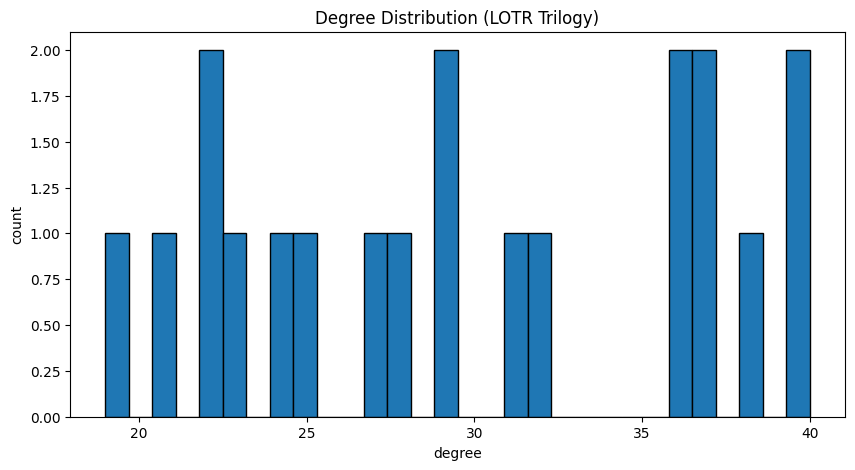


Centrality measures...

	top 10 by betweenness:
		Gandalf: 0.0388
		Aragorn II Elessar: 0.0388
		Samwise Gamgee: 0.0329
		Gollum: 0.0299
		Peregrin Took: 0.0268
		Gimli: 0.0259
		Frodo Baggins: 0.0234
		Meriadoc Brandybuck: 0.0132
		Boromir: 0.0120
		Théoden: 0.0120

Comparing different centrality measures...

	correlation: 0.954


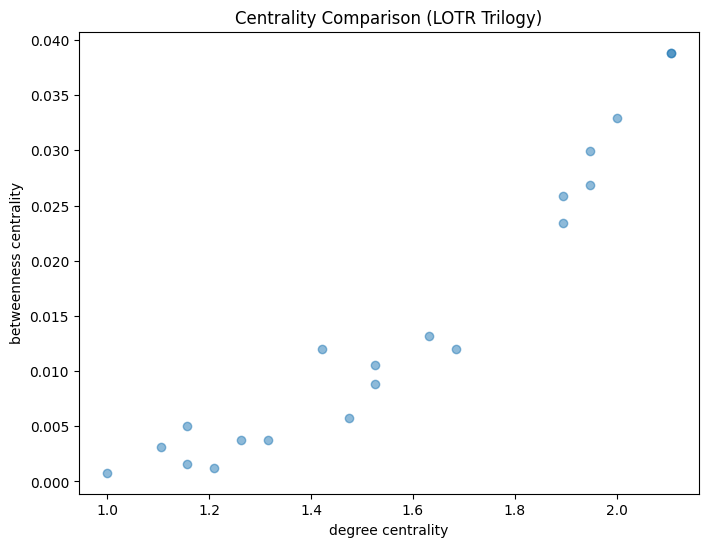


Assortativity analysis...

	degree assortativity: -0.1680
	network is disassortative (high-degree nodes connect to low-degree nodes)

Shortest path analysis...
	average shortest path: 1.268
	diameter: 2


In [95]:
# GRAPH INFO ANALYSIS

print("\nGraph Details (LOTR Trilogy):\n")
# Remove isolated nodes
isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)
print(f"\tAfter removing isolated nodes: {G.number_of_nodes()} nodes remain")

# Extract Giant Connected Component (GCC)
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_directed_gcc = G.subgraph(largest_cc).copy()

print(f"\n\tDirected GCC: {G_directed_gcc.number_of_nodes()} nodes, {G_directed_gcc.number_of_edges()} edges")

# Create undirected version
G_undirected_gcc = G_directed_gcc.to_undirected()
print(f"\tUndirected GCC: {G_undirected_gcc.number_of_nodes()} nodes, {G_undirected_gcc.number_of_edges()} edges")

# Degree distribution analysis
print("\nDegree distribution analysis...\n")
# get degrees
degrees = [G.degree(n) for n in G.nodes()]

print(f'\tavg degree: {np.mean(degrees):.2f}')
print(f'\tmax degree: {max(degrees)}')

plt.figure(figsize=(10, 5))
plt.hist(degrees, bins=30, edgecolor='black')
plt.xlabel('degree')
plt.ylabel('count')
plt.title('Degree Distribution (LOTR Trilogy)')
plt.show()

# Centrality measures
print("\nCentrality measures...\n")
# calculate centralities
deg_cent = nx.degree_centrality(G)
between_cent = nx.betweenness_centrality(G)
close_cent = nx.closeness_centrality(G)

# top nodes by betweenness
top_between = sorted(between_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print('\ttop 10 by betweenness:')
for node, val in top_between:
    print(f"\t\t{G.nodes[node]['label']}: {val:.4f}")


# Comparing different centrality measures
print("\nComparing different centrality measures...\n")
# compare degree and betweenness
nodes = list(G.nodes())
deg_vals = [deg_cent[n] for n in nodes]
bet_vals = [between_cent[n] for n in nodes]

corr = np.corrcoef(deg_vals, bet_vals)[0, 1]
print(f'\tcorrelation: {corr:.3f}')

plt.figure(figsize=(8, 6))
plt.scatter(deg_vals, bet_vals, alpha=0.5)
plt.xlabel('degree centrality')
plt.ylabel('betweenness centrality')
plt.title('Centrality Comparison (LOTR Trilogy)')
plt.show()

# Assortativity analysis
print("\nAssortativity analysis...\n")
# degree assortativity
assort = nx.degree_assortativity_coefficient(G)
print(f'\tdegree assortativity: {assort:.4f}')

if assort > 0:
    print('\tnetwork is assortative (high-degree nodes connect to high-degree nodes)')
else:
    print('\tnetwork is disassortative (high-degree nodes connect to low-degree nodes)')

# Shortest path analysis
print("\nShortest path analysis...")
# check if strongly connected
if nx.is_strongly_connected(G):
    avg_path = nx.average_shortest_path_length(G)
    print(f'\taverage shortest path: {avg_path:.3f}')
    diameter = nx.diameter(G)
    print(f'\tdiameter: {diameter}')
else:
    # use largest strongly connected component
    largest = max(nx.strongly_connected_components(G), key=len)
    G_largest = G.subgraph(largest)
    avg_path = nx.average_shortest_path_length(G_largest)
    print(f'\taverage shortest path (largest component): {avg_path:.3f}')
    diameter = nx.diameter(G_largest)
    print(f'\tdiameter: {diameter}')


## Part 9: Export Results

Save the results for further analysis.


In [96]:
# Create summary dataframe
summary_data = []
for char_id in character_sentiments.keys():
    summary_data.append({
        'character_id': char_id,
        'character_name': char_id_to_name.get(char_id, char_id),
        'sentiment': character_sentiments[char_id],
        'dialogue_count': character_dialogue_counts[char_id],
        'race': char_id_to_race.get(char_id, 'Unknown'),
        'gender': char_id_to_gender.get(char_id, 'Unknown')
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('sentiment', ascending=False)

print("\nSummary DataFrame created (LOTR Trilogy):")
print(df_summary.head(10))

# Optionally save to CSV
# df_summary.to_csv('lotr_trilogy_character_sentiment.csv', index=False)
# print("\nResults saved to 'lotr_trilogy_character_sentiment.csv'")



Summary DataFrame created (LOTR Trilogy):
                character_id       character_name  sentiment  dialogue_count  \
3   5cd99d4bde30eff6ebccfe9e               Gollum   5.344432             183   
19  5cd99d4bde30eff6ebccfc38        Bilbo Baggins   5.267902              47   
7   5cd99d4bde30eff6ebccfc7c  Meriadoc Brandybuck   5.136164             137   
2   5cd99d4bde30eff6ebccfc15        Frodo Baggins   5.057399             229   
8   5cd99d4bde30eff6ebccfe2e        Peregrin Took   5.034265             165   
6   5cd99d4bde30eff6ebccfd23                Gimli   5.030552             115   
11  5cd99d4bde30eff6ebccfbe6   Aragorn II Elessar   5.030116             212   
14  5cd99d4bde30eff6ebccfc9a          Denethor II   5.019072              45   
16  5cd99d4bde30eff6ebccfc07                Arwen   5.018000              40   
18  5cd99d4bde30eff6ebccfea4              Saruman   5.012063              39   

      race  gender  
3   Hobbit    Male  
19  Hobbit    Male  
7   Hobbit   

## Conclusion

This notebook has analyzed both the network structure of character interactions in the Lord of the Rings trilogy (The Fellowship of the Ring, The Two Towers, and The Return of the King) and the sentiment of their dialogues. Key findings:

1. **Overall Sentiment**: The average sentiment across all characters' dialogues in the trilogy
2. **Character Sentiment**: Identified the happiest and saddest characters based on their dialogue
3. **Movie Sentiment**: Compared sentiment across the three movies
4. **Network-Sentiment Relationship**: Explored correlations between network centrality and dialogue sentiment
5. **Network Properties**: Analyzed the structural properties of the character interaction network

This analysis provides insights into both the structural importance of characters (through network analysis) and the emotional tone of their speech (through sentiment analysis) within the LOTR trilogy.
